In [1]:
import warnings

warnings.filterwarnings("ignore")

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.feature_selection import SelectKBest, RFE, f_regression, SequentialFeatureSelector
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, PolynomialFeatures


# local
from wrangle import acquire_zillow, clean_zillow, wrangle_zillow, train_val_test, xy_split
from explore import dist_of_nums, plot_variable_pairs, plot_categorical_and_continuous_vars, evaluate_correlation
from evaluate import plot_residuals, regression_errors, baseline_mean_errors, better_than_baseline
from model import eval_model, train_model, train_and_evaluate_model, scale_data
from math import sqrt


# custom imports
import wrangle as w
import prepare as p
import explore as e

# AQUISITION PHASE OF DATA

In [2]:
### Query used to filter data from database,

# SELECT *

# SELECT bathroomcnt, bedroomcnt, calculatedbathnbr, calculatedfinishedsquarefeet, fips, fullbathcnt, garagecarcnt, 
# garagetotalsqft, heatingorsystemtypeid, latitude, longitude, lotsizesquarefeet, poolcnt, propertycountylandusecode, propertyzoningdesc, 
# rawcensustractandblock, regionidcity, regionidcounty, regionidneighborhood, regionidzip, roomcnt, unitcnt, yearbuilt, numberofstories,  
# taxvaluedollarcnt, assessmentyear, censustractandblock

# FROM properties_2017 AS p17
# LEFT JOIN predictions_2017 AS pr17 ON p17.id = pr17.id
# LEFT JOIN propertylandusetype AS plu ON p17.propertylandusetypeid = plu.propertylandusetypeid
# WHERE plu.propertylandusetypeid = 261 AND YEAR(pr17.transactiondate) = 2017; -- 'Single Family Residential' and transactions in 2017

In [3]:
# changed key id to for sql query above. 
# Parcel_id seems to be a more unique identifier versus the general id, the general id can be ambiguous so it's better to use parcel id to not have mismatched properties with identifier.

# went ahead and changed the query again to return wanted columns instead of generating 65 columns
# adjsted a third time to get columns with only a few null values

In [4]:
# Constants
filename = 'zillow_data.csv'

# Acquire data.
# ----------------------ACQUIRE FUNCTION---------------------------------
def acquire_zillow():

    if os.path.isfile(filename):
        
        return pd.read_csv(filename)
        
    else: 

        query = '''
        SELECT p17.parcelid, bathroomcnt, bedroomcnt, calculatedfinishedsquarefeet, fullbathcnt, latitude, longitude, lotsizesquarefeet,
        regionidcounty, regionidzip, roomcnt, yearbuilt, taxvaluedollarcnt, censustractandblock, fips
        FROM properties_2017 AS p17
        LEFT JOIN predictions_2017 AS pr17 ON p17.parcelid = pr17.parcelid
        LEFT JOIN propertylandusetype AS plu ON p17.propertylandusetypeid = plu.propertylandusetypeid
        WHERE plu.propertylandusetypeid = 261 AND YEAR(pr17.transactiondate) = 2017; -- 'Single Family Residential' and transactions in 2017
        '''

        url = get_connection('zillow')
                
        df = pd.read_sql(query, url)

        # # save to csv
        # df.to_csv(filename,index=False)

        return df 

In [5]:
# acquiring data
df = w.acquire_zillow()
df.head()

,parcel_id,bathrooms,bedrooms,area,full_bath_cnt,latitude,longitude,lot_area,region_id_county,regionidzip,room_cnt,year_built,home_value,census_tract_and_block,fips,state,county
0,14297519,3.5,4,3100,3,33634931.0,-117869207.0,4506,1286,96978,0,1998,1023282,6.059063e+13,6059,California,Orange County
1,17052889,1.0,2,1465,1,34449266.0,-119281531.0,12647,2061,97099,5,1967,464000,6.111001e+13,6111,California,Ventura County
2,14186244,2.0,3,1243,2,33886168.0,-117823170.0,8432,1286,97078,6,1962,564778,6.059022e+13,6059,California,Orange County
3,12177905,3.0,4,2376,3,34245180.0,-118240722.0,13038,3101,96330,0,1970,145143,6.037300e+13,6037,California,Los Angeles County
4,12095076,3.0,4,2962,3,34145202.0,-118179824.0,63000,3101,96293,0,1950,773303,6.037461e+13,6037,California,Los Angeles County


In [6]:
# checking shape of data
df.shape

(51732, 17)

In [7]:
# checking info of data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51732 entries, 0 to 51731
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   parcel_id               51732 non-null  int64  
 1   bathrooms               51732 non-null  float64
 2   bedrooms                51732 non-null  int64  
 3   area                    51732 non-null  int64  
 4   full_bath_cnt           51732 non-null  int64  
 5   latitude                51732 non-null  float64
 6   longitude               51732 non-null  float64
 7   lot_area                51732 non-null  int64  
 8   region_id_county        51732 non-null  int64  
 9   regionidzip             51732 non-null  int64  
 10  room_cnt                51732 non-null  int64  
 11  year_built              51732 non-null  int64  
 12  home_value              51732 non-null  int64  
 13  census_tract_and_block  51732 non-null  float64
 14  fips                    51732 non-null

# PREP PHASE OF DATA

In [8]:
# created dup to see how many duplicated rows are in my data frame
dup = df.duplicated() == True
dup.sum()

0

In [9]:
dup = df.duplicated() == False
dup.sum()

51732

In [10]:
dup = df[df.duplicated() == True]
dup.shape

(0, 17)

In [11]:
# double checked for all features again for duplicates
all_duplicates = df[df.duplicated(keep='first')]
all_duplicates

,parcel_id,bathrooms,bedrooms,area,full_bath_cnt,latitude,longitude,lot_area,region_id_county,regionidzip,room_cnt,year_built,home_value,census_tract_and_block,fips,state,county


In [12]:
# wanted to see if the rows are actually in fact duplicated and I confirmed with a boolean mask to return rows with the same parcelid
# parcelid should be a unique identifier for these properties
dups = df[df['parcel_id'] == 11721753]
dups

,parcel_id,bathrooms,bedrooms,area,full_bath_cnt,latitude,longitude,lot_area,region_id_county,regionidzip,room_cnt,year_built,home_value,census_tract_and_block,fips,state,county
664,11721753,2.0,3,1316,2,34033180.0,-118355396.0,5672,3101,95997,0,1923,205123,6.037220e+13,6037,California,Los Angeles County


In [13]:
# found a parcelid with more than 2 duplicates, realizing multiple with different dates as long features of one property stay in the dataframe should be fine
dups = df[df['parcel_id'] == 11991059]
dups

,parcel_id,bathrooms,bedrooms,area,full_bath_cnt,latitude,longitude,lot_area,region_id_county,regionidzip,room_cnt,year_built,home_value,census_tract_and_block,fips,state,county


In [14]:
# checked for all parcelid duplicates and I identified 241 rows
duplicate_parcelids = df[df.duplicated(subset=['parcel_id'], keep=False)]
duplicate_parcelids.shape

(0, 17)

In [15]:
52441 - 52320

121

In [16]:
# ~ is used to exclude the rows with duplicate 'parcelid' values from the DataFrame by inverting the boolean Series that identifies duplicates.
df = df[~df.duplicated(keep='first')]
df.shape

(51732, 17)

In [17]:
# double checked for all features again for duplicates
all_duplicates = df[df.duplicated(keep=False)]
all_duplicates

,parcel_id,bathrooms,bedrooms,area,full_bath_cnt,latitude,longitude,lot_area,region_id_county,regionidzip,room_cnt,year_built,home_value,census_tract_and_block,fips,state,county


In [18]:
# double checked by parcelid column again for duplicates
duplicate_parcelids = df[df.duplicated(subset=['parcel_id'], keep=False)]
duplicate_parcelids.shape

(0, 17)

In [19]:
df.head()

,parcel_id,bathrooms,bedrooms,area,full_bath_cnt,latitude,longitude,lot_area,region_id_county,regionidzip,room_cnt,year_built,home_value,census_tract_and_block,fips,state,county
0,14297519,3.5,4,3100,3,33634931.0,-117869207.0,4506,1286,96978,0,1998,1023282,6.059063e+13,6059,California,Orange County
1,17052889,1.0,2,1465,1,34449266.0,-119281531.0,12647,2061,97099,5,1967,464000,6.111001e+13,6111,California,Ventura County
2,14186244,2.0,3,1243,2,33886168.0,-117823170.0,8432,1286,97078,6,1962,564778,6.059022e+13,6059,California,Orange County
3,12177905,3.0,4,2376,3,34245180.0,-118240722.0,13038,3101,96330,0,1970,145143,6.037300e+13,6037,California,Los Angeles County
4,12095076,3.0,4,2962,3,34145202.0,-118179824.0,63000,3101,96293,0,1950,773303,6.037461e+13,6037,California,Los Angeles County


In [20]:
# checked for all null values; i may be losing approximately 37788 columns in df
df.isna().sum()

parcel_id                 0
bathrooms                 0
bedrooms                  0
area                      0
full_bath_cnt             0
latitude                  0
longitude                 0
lot_area                  0
region_id_county          0
regionidzip               0
room_cnt                  0
year_built                0
home_value                0
census_tract_and_block    0
fips                      0
state                     0
county                    0
dtype: int64

I may impute some values for features with less than 500 null values, and drop anything over that.

In [21]:
# df[df['unitcnt'] == 1.0] # may impute 1.0 for unitcnt

In [22]:
# dropping all nulls erases all rows; can't do that, i have to figure out another way to prep data
df2 = df.dropna()
df2

,parcel_id,bathrooms,bedrooms,area,full_bath_cnt,latitude,longitude,lot_area,region_id_county,regionidzip,room_cnt,year_built,home_value,census_tract_and_block,fips,state,county
0,14297519,3.5,4,3100,3,33634931.0,-117869207.0,4506,1286,96978,0,1998,1023282,6.059063e+13,6059,California,Orange County
1,17052889,1.0,2,1465,1,34449266.0,-119281531.0,12647,2061,97099,5,1967,464000,6.111001e+13,6111,California,Ventura County
2,14186244,2.0,3,1243,2,33886168.0,-117823170.0,8432,1286,97078,6,1962,564778,6.059022e+13,6059,California,Orange County
3,12177905,3.0,4,2376,3,34245180.0,-118240722.0,13038,3101,96330,0,1970,145143,6.037300e+13,6037,California,Los Angeles County
4,12095076,3.0,4,2962,3,34145202.0,-118179824.0,63000,3101,96293,0,1950,773303,6.037461e+13,6037,California,Los Angeles County
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51727,12412492,2.0,4,1633,2,33870815.0,-118070858.0,4630,3101,96204,0,1962,346534,6.037555e+13,6037,California,Los Angeles County
51728,11000655,2.0,2,1286,2,34245368.0,-118282383.0,47405,3101,96284,0,1940,354621,6.037101e+13,6037,California,Los Angeles County
51729,17239384,2.0,4,1612,2,34300140.0,-118706327.0,12105,2061,97116,7,1964,67205,6.111008e+13,6111,California,Ventura County
51730,12773139,1.0,3,1032,1,34040895.0,-118038169.0,5074,3101,96480,0,1954,49546,6.037434e+13,6037,California,Los Angeles County


In [23]:
# dropped columns with large null values
# df = df.drop(columns=['garagecarcnt', 'garagetotalsqft', 'heatingorsystemtypeid', 'poolcnt', 'propertyzoningdesc', 'regionidcity', 'regionidneighborhood', 'unitcnt', 'numberofstories']) 

In [24]:
df.head()

,parcel_id,bathrooms,bedrooms,area,full_bath_cnt,latitude,longitude,lot_area,region_id_county,regionidzip,room_cnt,year_built,home_value,census_tract_and_block,fips,state,county
0,14297519,3.5,4,3100,3,33634931.0,-117869207.0,4506,1286,96978,0,1998,1023282,6.059063e+13,6059,California,Orange County
1,17052889,1.0,2,1465,1,34449266.0,-119281531.0,12647,2061,97099,5,1967,464000,6.111001e+13,6111,California,Ventura County
2,14186244,2.0,3,1243,2,33886168.0,-117823170.0,8432,1286,97078,6,1962,564778,6.059022e+13,6059,California,Orange County
3,12177905,3.0,4,2376,3,34245180.0,-118240722.0,13038,3101,96330,0,1970,145143,6.037300e+13,6037,California,Los Angeles County
4,12095076,3.0,4,2962,3,34145202.0,-118179824.0,63000,3101,96293,0,1950,773303,6.037461e+13,6037,California,Los Angeles County


In [25]:
# checked shape
df.shape

(51732, 17)

In [26]:
# checked to see my resulting df info, there are less large null counts  so now i can probably dropna() and not lose my entire data.
df.isna().sum()

parcel_id                 0
bathrooms                 0
bedrooms                  0
area                      0
full_bath_cnt             0
latitude                  0
longitude                 0
lot_area                  0
region_id_county          0
regionidzip               0
room_cnt                  0
year_built                0
home_value                0
census_tract_and_block    0
fips                      0
state                     0
county                    0
dtype: int64

In [27]:
# dropping all columns of current df
df = df.dropna()
df.shape

(51732, 17)

In [28]:
# checking for null values again
df.isna().sum()

parcel_id                 0
bathrooms                 0
bedrooms                  0
area                      0
full_bath_cnt             0
latitude                  0
longitude                 0
lot_area                  0
region_id_county          0
regionidzip               0
room_cnt                  0
year_built                0
home_value                0
census_tract_and_block    0
fips                      0
state                     0
county                    0
dtype: int64

In [29]:
# checking shape, looks like my dataframe was reduced to approximately 600 rows that contained null values
df.shape

(51732, 17)

In [30]:
# make sure the math is mathing
52320 - 51732

588

In [31]:
# looking over the column names see if I can change these to be more pythonic
df.dtypes

parcel_id                   int64
bathrooms                 float64
bedrooms                    int64
area                        int64
full_bath_cnt               int64
latitude                  float64
longitude                 float64
lot_area                    int64
region_id_county            int64
regionidzip                 int64
room_cnt                    int64
year_built                  int64
home_value                  int64
census_tract_and_block    float64
fips                        int64
state                      object
county                     object
dtype: object

In [32]:
# renamed appropriately
df = df.rename(columns={'bedroomcnt': 'bedrooms', 'bathroomcnt': 'bathrooms', 
                            'calculatedfinishedsquarefeet': 'area', 'taxvaluedollarcnt': 'home_value', 
                            'yearbuilt': 'year_built', 'fullbathcnt' : 'full_bath_cnt', 'lotsizesquarefeet' : 'lot_area', 'regionidcounty' : 'region_id_county',
                            'roomcnt' : 'room_cnt', 'censustractandblock' : 'census_tract_and_block'})

In [33]:
# looking at dataframe to ensure changes were made to columns
df.head()

,parcel_id,bathrooms,bedrooms,area,full_bath_cnt,latitude,longitude,lot_area,region_id_county,regionidzip,room_cnt,year_built,home_value,census_tract_and_block,fips,state,county
0,14297519,3.5,4,3100,3,33634931.0,-117869207.0,4506,1286,96978,0,1998,1023282,6.059063e+13,6059,California,Orange County
1,17052889,1.0,2,1465,1,34449266.0,-119281531.0,12647,2061,97099,5,1967,464000,6.111001e+13,6111,California,Ventura County
2,14186244,2.0,3,1243,2,33886168.0,-117823170.0,8432,1286,97078,6,1962,564778,6.059022e+13,6059,California,Orange County
3,12177905,3.0,4,2376,3,34245180.0,-118240722.0,13038,3101,96330,0,1970,145143,6.037300e+13,6037,California,Los Angeles County
4,12095076,3.0,4,2962,3,34145202.0,-118179824.0,63000,3101,96293,0,1950,773303,6.037461e+13,6037,California,Los Angeles County


In [34]:
# can i change the dtypes from flot to int for most of these?
df.dtypes

parcel_id                   int64
bathrooms                 float64
bedrooms                    int64
area                        int64
full_bath_cnt               int64
latitude                  float64
longitude                 float64
lot_area                    int64
region_id_county            int64
regionidzip                 int64
room_cnt                    int64
year_built                  int64
home_value                  int64
census_tract_and_block    float64
fips                        int64
state                      object
county                     object
dtype: object

In [35]:
# used list of columns to change datatyoes from float to int.
int_columns = ['fips', 'year_built', 'home_value', 'area', 'bedrooms', 'full_bath_cnt', 'room_cnt', 'region_id_county', 'regionidzip', 'lot_area']
df[int_columns] = df[int_columns].astype(int)

In [36]:
# dtypes are now appropriately set
df.dtypes

parcel_id                   int64
bathrooms                 float64
bedrooms                    int32
area                        int32
full_bath_cnt               int32
latitude                  float64
longitude                 float64
lot_area                    int32
region_id_county            int32
regionidzip                 int32
room_cnt                    int32
year_built                  int32
home_value                  int32
census_tract_and_block    float64
fips                        int32
state                      object
county                     object
dtype: object

In [37]:
# looking for additional prep steps
df.head()

,parcel_id,bathrooms,bedrooms,area,full_bath_cnt,latitude,longitude,lot_area,region_id_county,regionidzip,room_cnt,year_built,home_value,census_tract_and_block,fips,state,county
0,14297519,3.5,4,3100,3,33634931.0,-117869207.0,4506,1286,96978,0,1998,1023282,6.059063e+13,6059,California,Orange County
1,17052889,1.0,2,1465,1,34449266.0,-119281531.0,12647,2061,97099,5,1967,464000,6.111001e+13,6111,California,Ventura County
2,14186244,2.0,3,1243,2,33886168.0,-117823170.0,8432,1286,97078,6,1962,564778,6.059022e+13,6059,California,Orange County
3,12177905,3.0,4,2376,3,34245180.0,-118240722.0,13038,3101,96330,0,1970,145143,6.037300e+13,6037,California,Los Angeles County
4,12095076,3.0,4,2962,3,34145202.0,-118179824.0,63000,3101,96293,0,1950,773303,6.037461e+13,6037,California,Los Angeles County


In [38]:
# Mapped state names to fips code

fips_to_state = {
    6037: 'California',
    6059: 'California',
    6111: 'California',
    # Add more mappings for other states as needed
    }

# Mapped county names to fips code
fips_to_county = {
    6037: 'Los Angeles County',
    6059: 'Orange County',
    6111: 'Ventura County',
    # Add more mappings for other counties as needed
    }

# Use the map method to create new 'county' and 'state' columns based on 'fips' column
df['state'] = df['fips'].map(fips_to_state)
df['county'] = df['fips'].map(fips_to_county)

In [39]:
# checking to see if the columns are added to the dataframe
df.head()

,parcel_id,bathrooms,bedrooms,area,full_bath_cnt,latitude,longitude,lot_area,region_id_county,regionidzip,room_cnt,year_built,home_value,census_tract_and_block,fips,state,county
0,14297519,3.5,4,3100,3,33634931.0,-117869207.0,4506,1286,96978,0,1998,1023282,6.059063e+13,6059,California,Orange County
1,17052889,1.0,2,1465,1,34449266.0,-119281531.0,12647,2061,97099,5,1967,464000,6.111001e+13,6111,California,Ventura County
2,14186244,2.0,3,1243,2,33886168.0,-117823170.0,8432,1286,97078,6,1962,564778,6.059022e+13,6059,California,Orange County
3,12177905,3.0,4,2376,3,34245180.0,-118240722.0,13038,3101,96330,0,1970,145143,6.037300e+13,6037,California,Los Angeles County
4,12095076,3.0,4,2962,3,34145202.0,-118179824.0,63000,3101,96293,0,1950,773303,6.037461e+13,6037,California,Los Angeles County


In [40]:
# defined function to clean the zillow data
def clean_zillow(df):
    """
    Cleans the Zillow data.
    
    Args:
    - df (DataFrame): Acquired Raw Zillow data.
    """

    # Drop rows with duplicates
    df = df[~df.duplicated(keep='first')]
    
    # Drop rows with missing/null values in any column
    df = df.dropna()

    # Rename columns
    df = df.rename(columns={'parcelid' : 'parcel_id', 'bedroomcnt': 'bedrooms',
                            'bathroomcnt':'bathrooms','calculatedfinishedsquarefeet': 'area',
                            'taxvaluedollarcnt': 'home_value','yearbuilt': 'year_built', 
                            'fullbathcnt' : 'full_bath_cnt','lotsizesquarefeet' : 'lot_area', 
                            'regionidcounty' : 'region_id_county', 'roomcnt' : 'room_cnt', 
                            'censustractandblock' : 'census_tract_and_block'})

    # Convert selected columns to integer type
    int_columns = ['fips', 'year_built', 'home_value', 'area', 'bedrooms', 'full_bath_cnt', 'room_cnt',
                   'region_id_county', 'regionidzip', 'lot_area']
    df[int_columns] = df[int_columns].astype(int)

    # Mapped state to fips code
    fips_to_state = {
        6037: 'California',
        6059: 'California',
        6111: 'California',
        # you may add more mappings for other states as needed
        }

    # Mapped county names to fips code
    fips_to_county = {
        6037: 'Los Angeles County',
        6059: 'Orange County',
        6111: 'Ventura County',
        # you may more mappings for other counties as needed
        }
    
    # Use the map method to create new 'county' and 'state' columns based on 'fips' column
    df['state'] = df['fips'].map(fips_to_state)
    df['county'] = df['fips'].map(fips_to_county)
    
    return df

In [41]:
df = w.clean_zillow(df)
df.head()

,parcel_id,bathrooms,bedrooms,area,full_bath_cnt,latitude,longitude,lot_area,region_id_county,regionidzip,room_cnt,year_built,home_value,census_tract_and_block,fips,state,county
0,14297519,3.5,4,3100,3,33634931.0,-117869207.0,4506,1286,96978,0,1998,1023282,6.059063e+13,6059,California,Orange County
1,17052889,1.0,2,1465,1,34449266.0,-119281531.0,12647,2061,97099,5,1967,464000,6.111001e+13,6111,California,Ventura County
2,14186244,2.0,3,1243,2,33886168.0,-117823170.0,8432,1286,97078,6,1962,564778,6.059022e+13,6059,California,Orange County
3,12177905,3.0,4,2376,3,34245180.0,-118240722.0,13038,3101,96330,0,1970,145143,6.037300e+13,6037,California,Los Angeles County
4,12095076,3.0,4,2962,3,34145202.0,-118179824.0,63000,3101,96293,0,1950,773303,6.037461e+13,6037,California,Los Angeles County


In [42]:
df.shape # checked

(51732, 17)

In [43]:
# dtypes includes objects, but they can be dropped for analysis of numerical features for this regression project.
df.dtypes

parcel_id                   int64
bathrooms                 float64
bedrooms                    int32
area                        int32
full_bath_cnt               int32
latitude                  float64
longitude                 float64
lot_area                    int32
region_id_county            int32
regionidzip                 int32
room_cnt                    int32
year_built                  int32
home_value                  int32
census_tract_and_block    float64
fips                        int32
state                      object
county                     object
dtype: object

### Now that i have taken care of all extraneous discrepancies within data i will now test my scale and split functions from the wrangle module

In [44]:
# data split worked!
train, val, test = w.train_val_test(df)
train.head()

,parcel_id,bathrooms,bedrooms,area,full_bath_cnt,latitude,longitude,lot_area,region_id_county,regionidzip,room_cnt,year_built,home_value,census_tract_and_block,fips,state,county
39762,12115385,2.0,3,1218,2,34164673.0,-118126949.0,9251,3101,96292,0,1921,432527,6.037462e+13,6037,California,Los Angeles County
48844,12825439,2.0,3,1662,2,33931418.0,-118001601.0,6455,3101,96172,0,1954,169135,6.037504e+13,6037,California,Los Angeles County
24439,12668213,1.0,3,1580,1,33821835.0,-118387104.0,7509,3101,96123,0,1948,163387,6.037621e+13,6037,California,Los Angeles County
48581,12266229,1.0,3,1079,1,33906624.0,-118240829.0,6249,3101,96092,0,1954,163308,6.037541e+13,6037,California,Los Angeles County
5570,14379497,3.0,4,1986,3,33611735.0,-117688925.0,7560,1286,96995,8,1968,461551,6.059032e+13,6059,California,Orange County


In [45]:
# xysplit of data is operational
X_train, y_train = w.xy_split(train, 'home_value')
X_train.head()

,parcel_id,bathrooms,bedrooms,area,full_bath_cnt,latitude,longitude,lot_area,region_id_county,regionidzip,room_cnt,year_built,census_tract_and_block,fips,state,county
39762,12115385,2.0,3,1218,2,34164673.0,-118126949.0,9251,3101,96292,0,1921,6.037462e+13,6037,California,Los Angeles County
48844,12825439,2.0,3,1662,2,33931418.0,-118001601.0,6455,3101,96172,0,1954,6.037504e+13,6037,California,Los Angeles County
24439,12668213,1.0,3,1580,1,33821835.0,-118387104.0,7509,3101,96123,0,1948,6.037621e+13,6037,California,Los Angeles County
48581,12266229,1.0,3,1079,1,33906624.0,-118240829.0,6249,3101,96092,0,1954,6.037541e+13,6037,California,Los Angeles County
5570,14379497,3.0,4,1986,3,33611735.0,-117688925.0,7560,1286,96995,8,1968,6.059032e+13,6059,California,Orange County


# EXPLORE PHASE OF DATA

In [46]:
# reading in data using function and checking shape
df = w.wrangle_zillow()
train, val, test = p.train_val_test(df)
train.shape, val.shape, test.shape

((36212, 17), (7760, 17), (7760, 17))

In [47]:
# looking at train subset info
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 36212 entries, 39762 to 15795
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   parcel_id               36212 non-null  int64  
 1   bathrooms               36212 non-null  float64
 2   bedrooms                36212 non-null  int32  
 3   area                    36212 non-null  int32  
 4   full_bath_cnt           36212 non-null  int32  
 5   latitude                36212 non-null  float64
 6   longitude               36212 non-null  float64
 7   lot_area                36212 non-null  int32  
 8   region_id_county        36212 non-null  int32  
 9   regionidzip             36212 non-null  int32  
 10  room_cnt                36212 non-null  int32  
 11  year_built              36212 non-null  int32  
 12  home_value              36212 non-null  int32  
 13  census_tract_and_block  36212 non-null  float64
 14  fips                    36212 non-null 

In [48]:
# sampling train becuase running function to visualize variable comparison will take alot longer
train = train.sample(100)

In [49]:
# plotted variables with all variables
# plot_variable_pairs(df)

In [50]:
# I will nowcall cat and continuous data comparison functions to display multiple visuals with different variables.

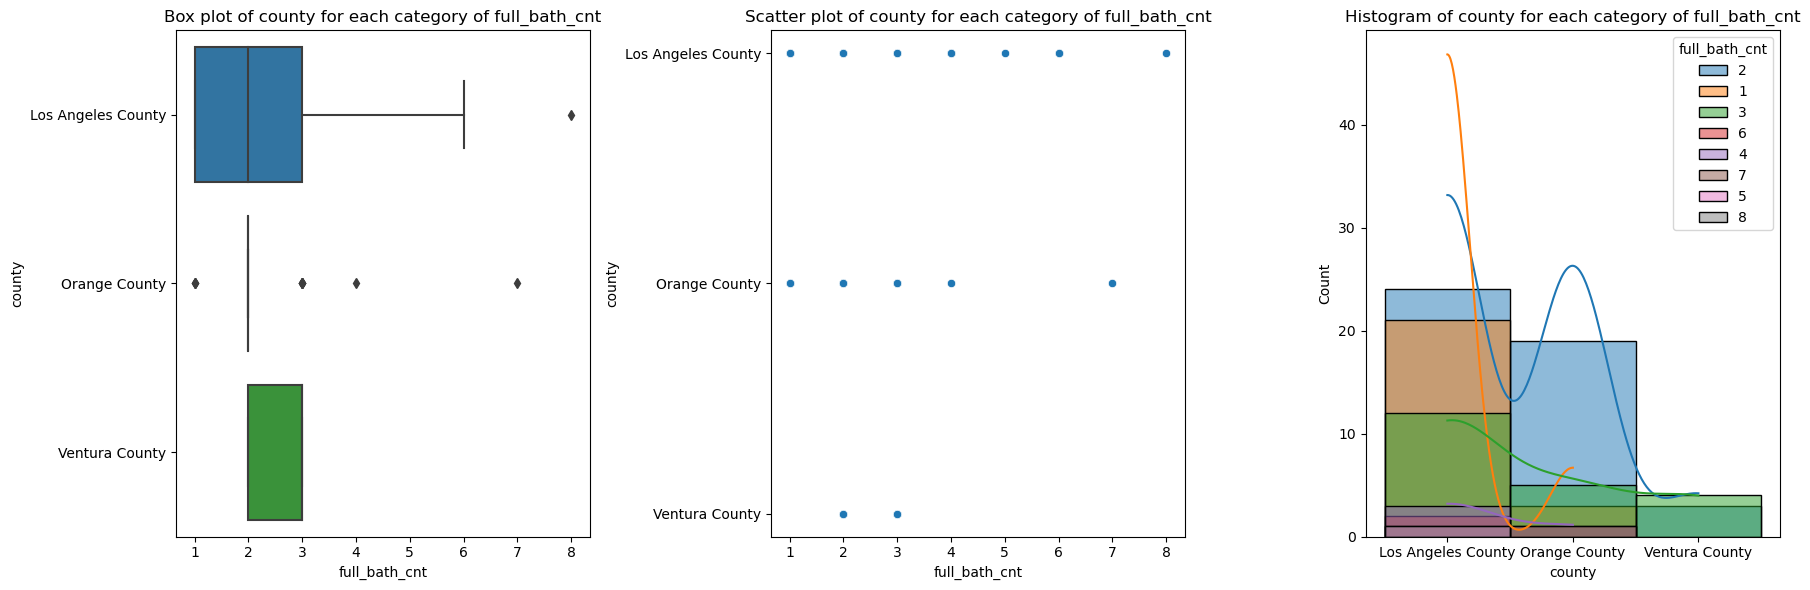

In [51]:
plot_categorical_and_continuous_vars(train, 'county', 'full_bath_cnt', n=(1, 1.5, 2, 2.5, 3, 3.5, 4, 20))

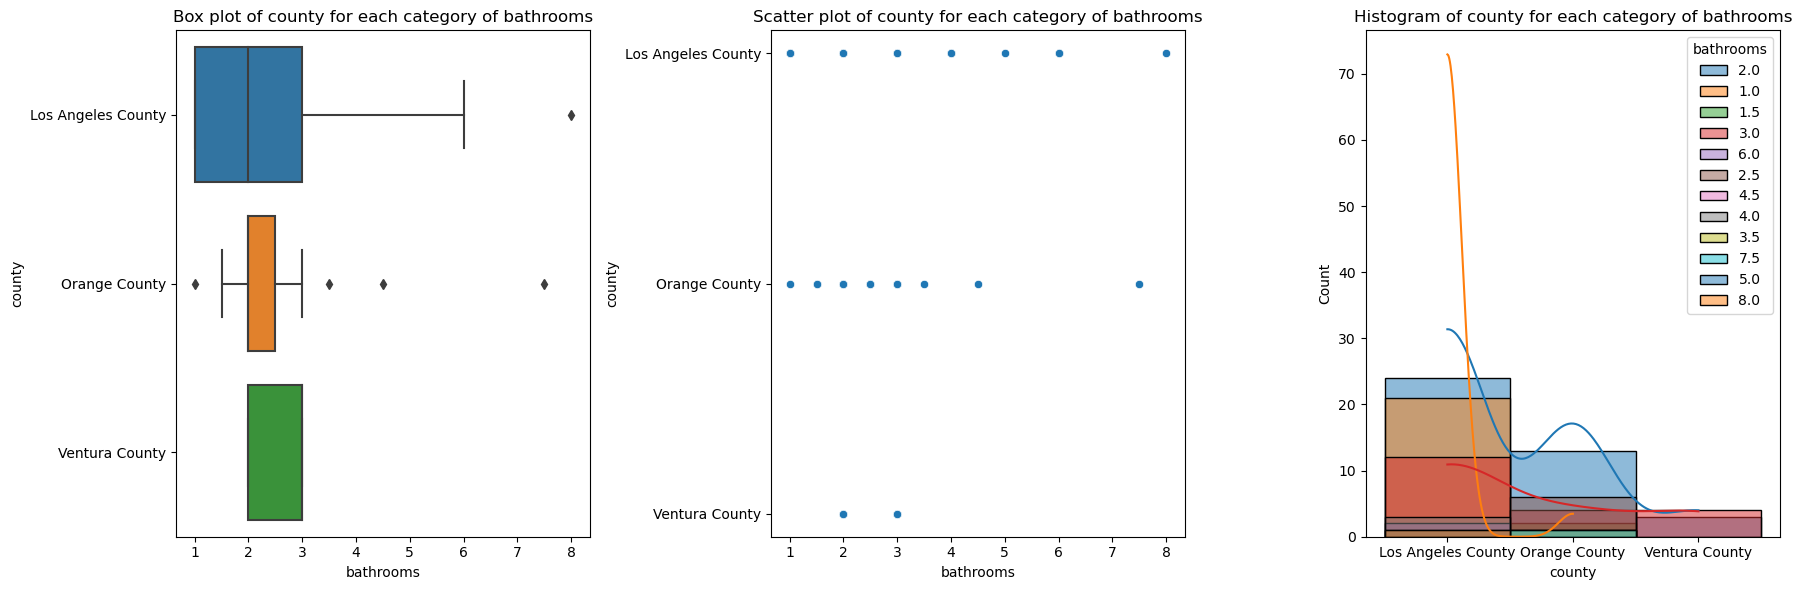

In [52]:
plot_categorical_and_continuous_vars(train, 'county', 'bathrooms', n=(1, 1.5, 2, 2.5, 3, 3.5, 4, 20))

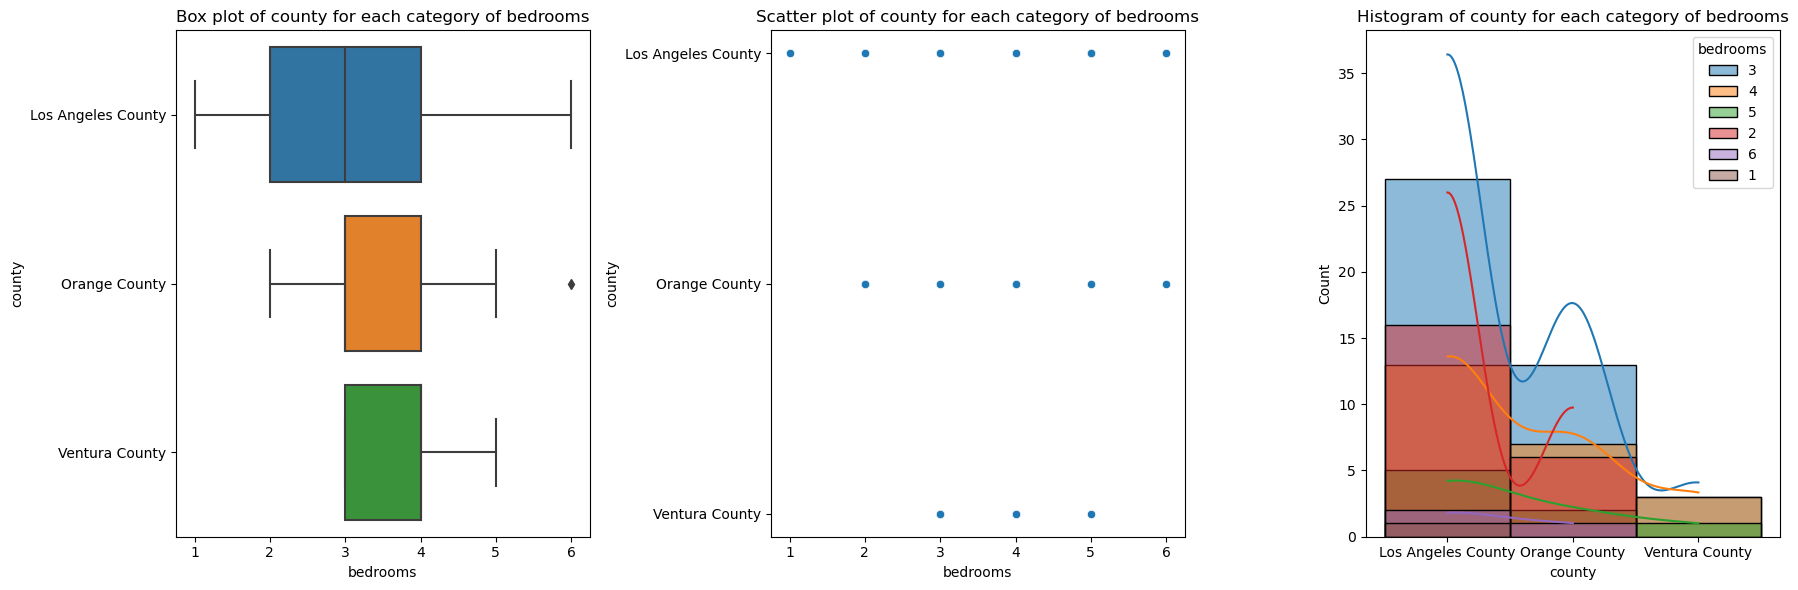

In [53]:
plot_categorical_and_continuous_vars(train, 'county', 'bedrooms', n=(0, 2.0, 4.0, 6.0, 20.0))

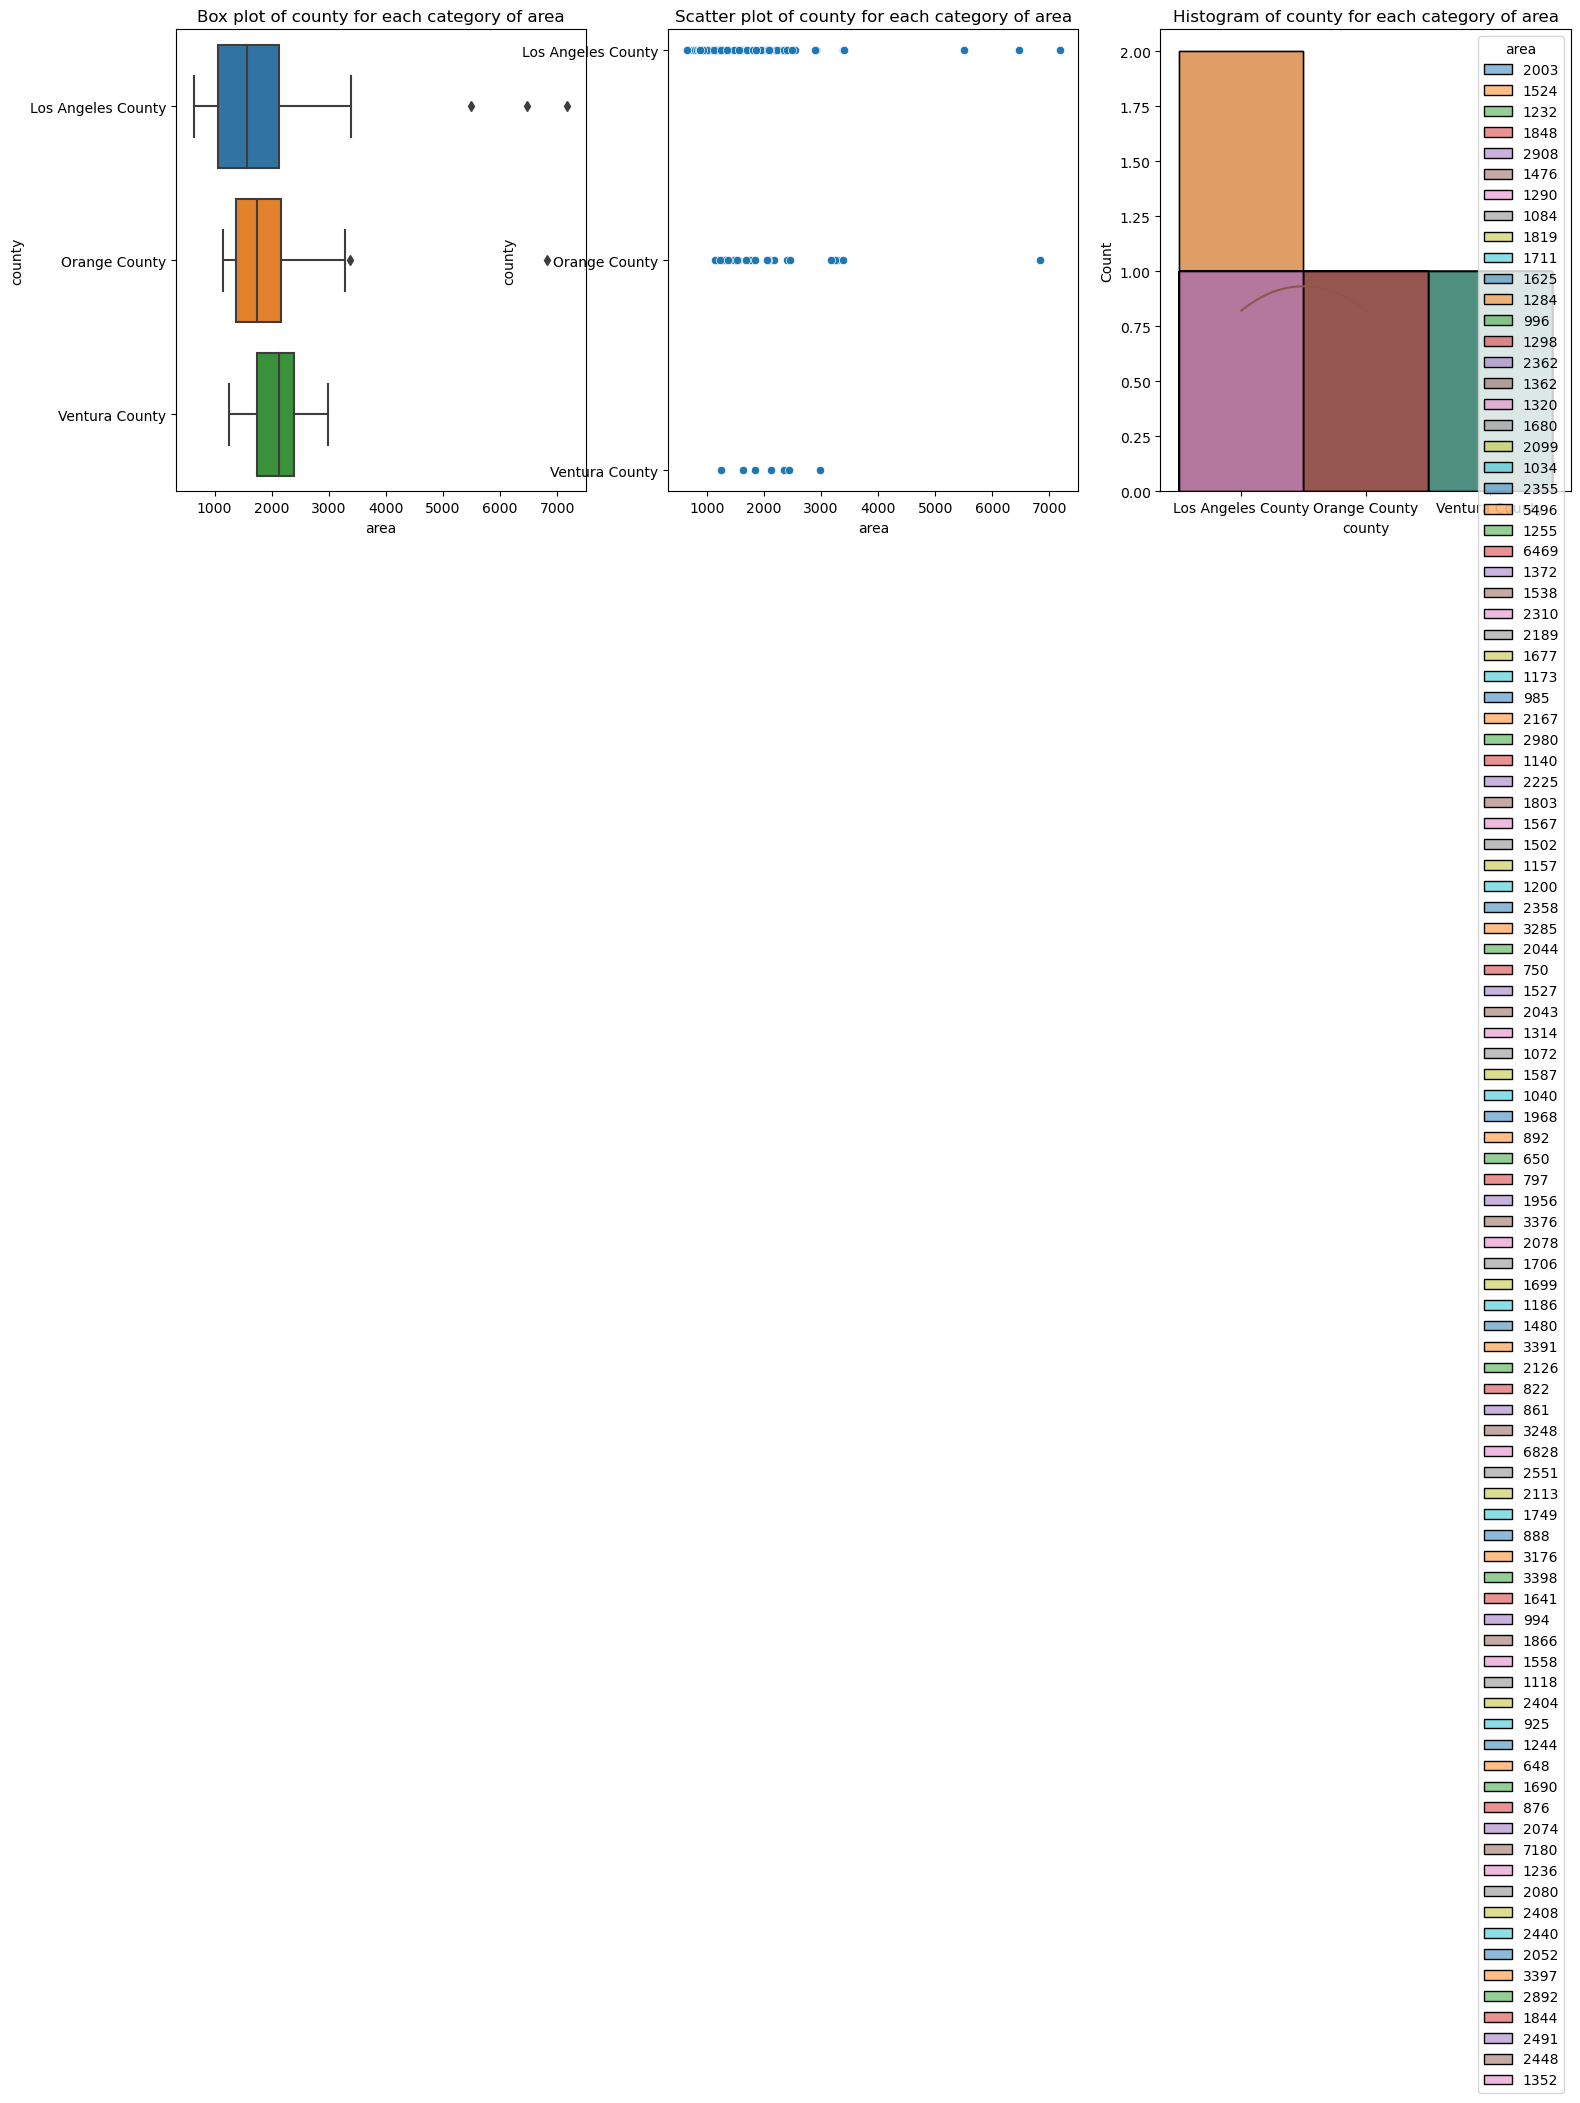

In [54]:
plot_categorical_and_continuous_vars(train, 'county', 'area', n=(675, 1350, 2700, 4000, 10000))

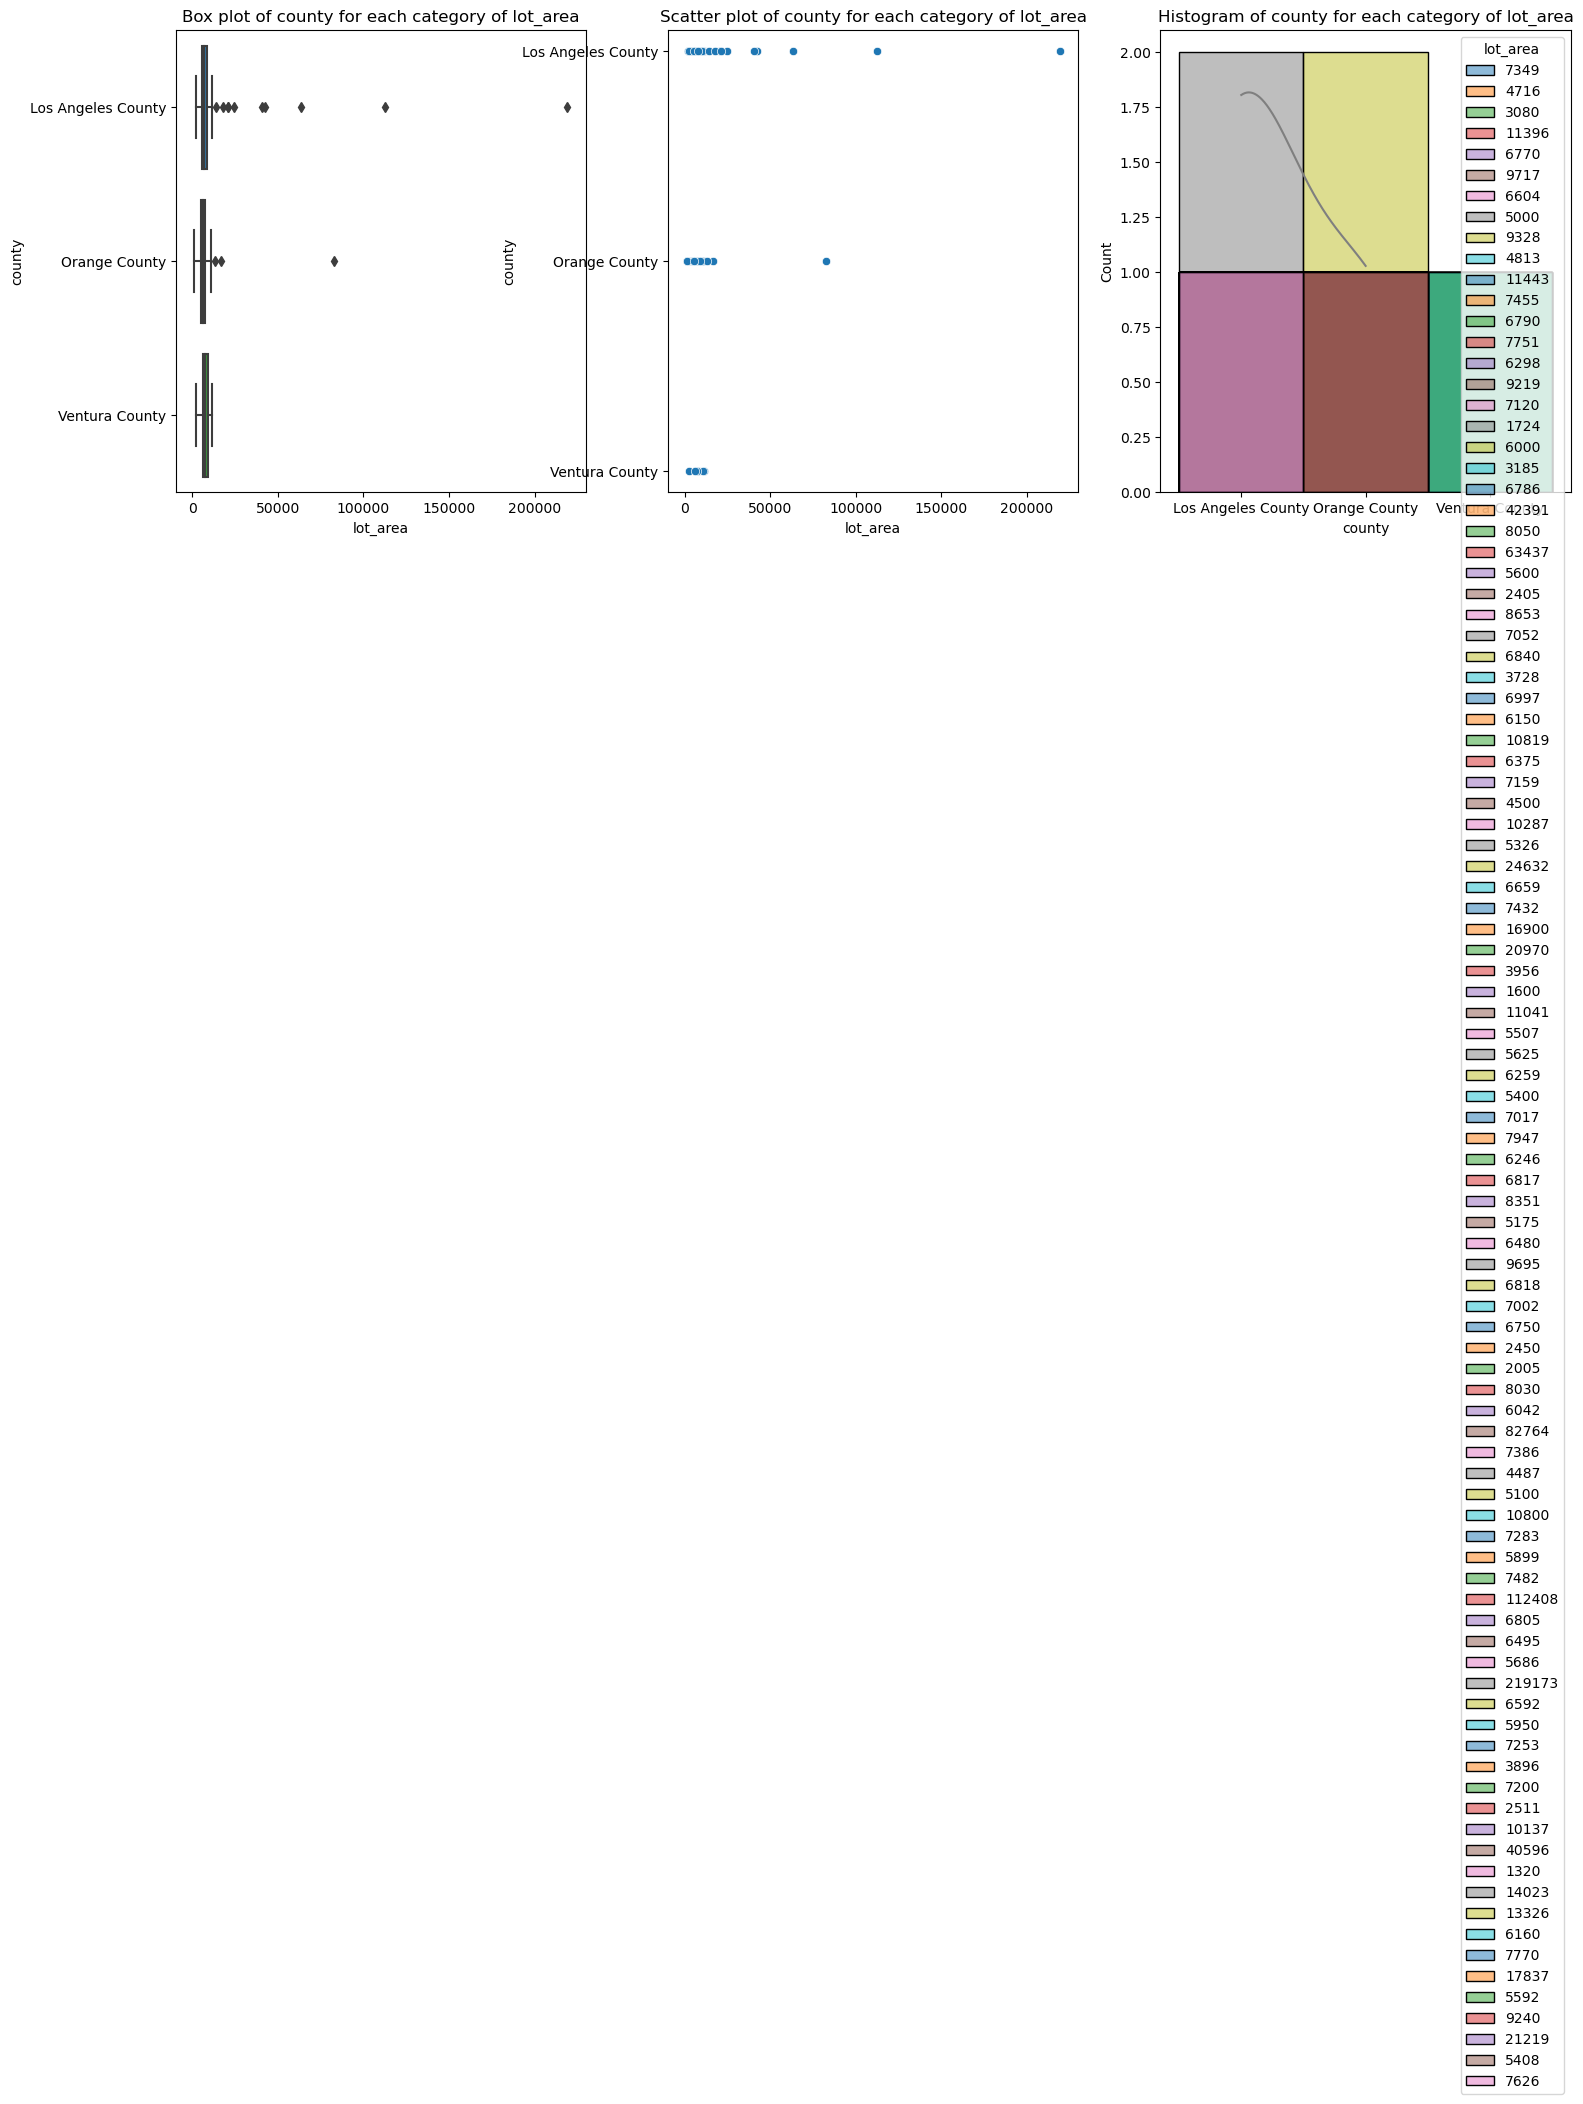

In [55]:
plot_categorical_and_continuous_vars(train, 'county', 'lot_area', n=(0, 675, 1350, 2700, 4000, 10000, 3000))

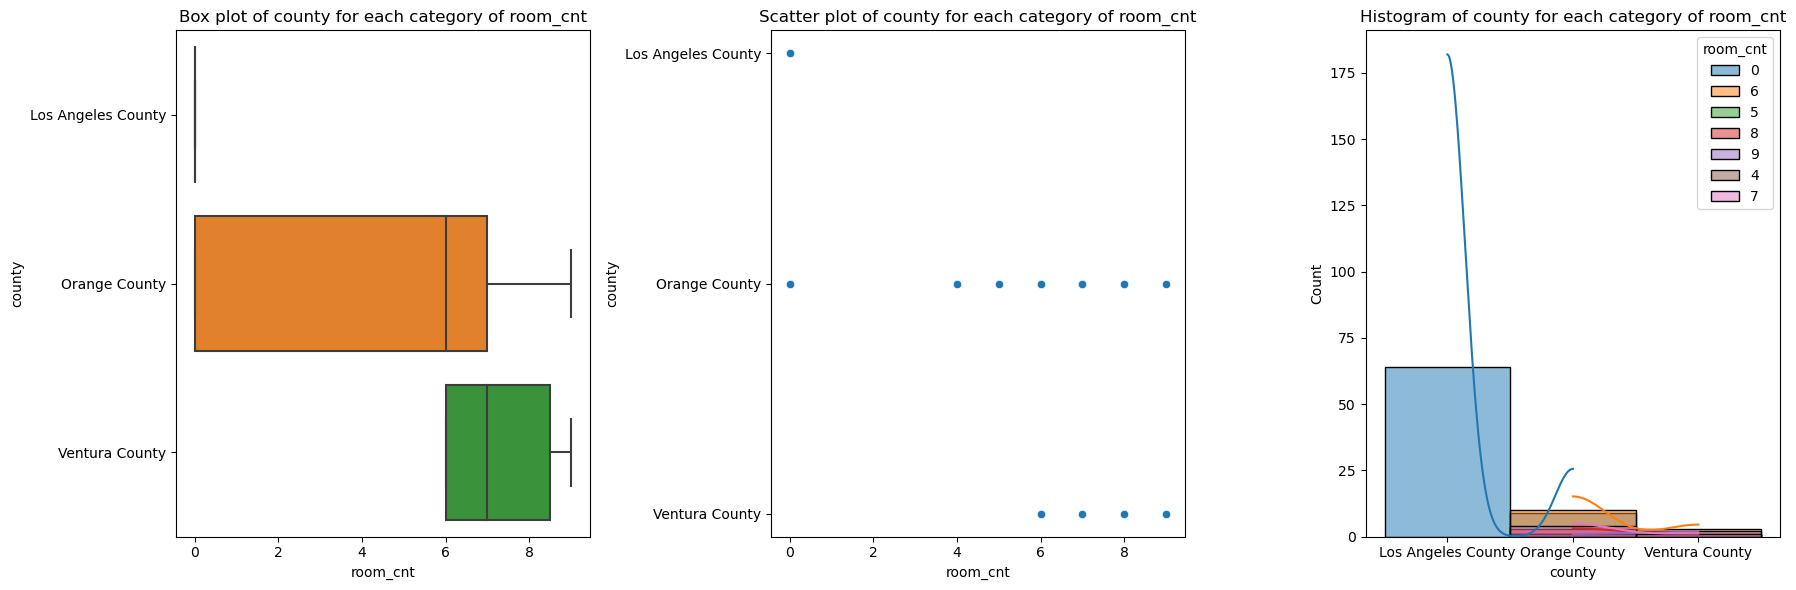

In [56]:
plot_categorical_and_continuous_vars(train, 'county', 'room_cnt', n=None)

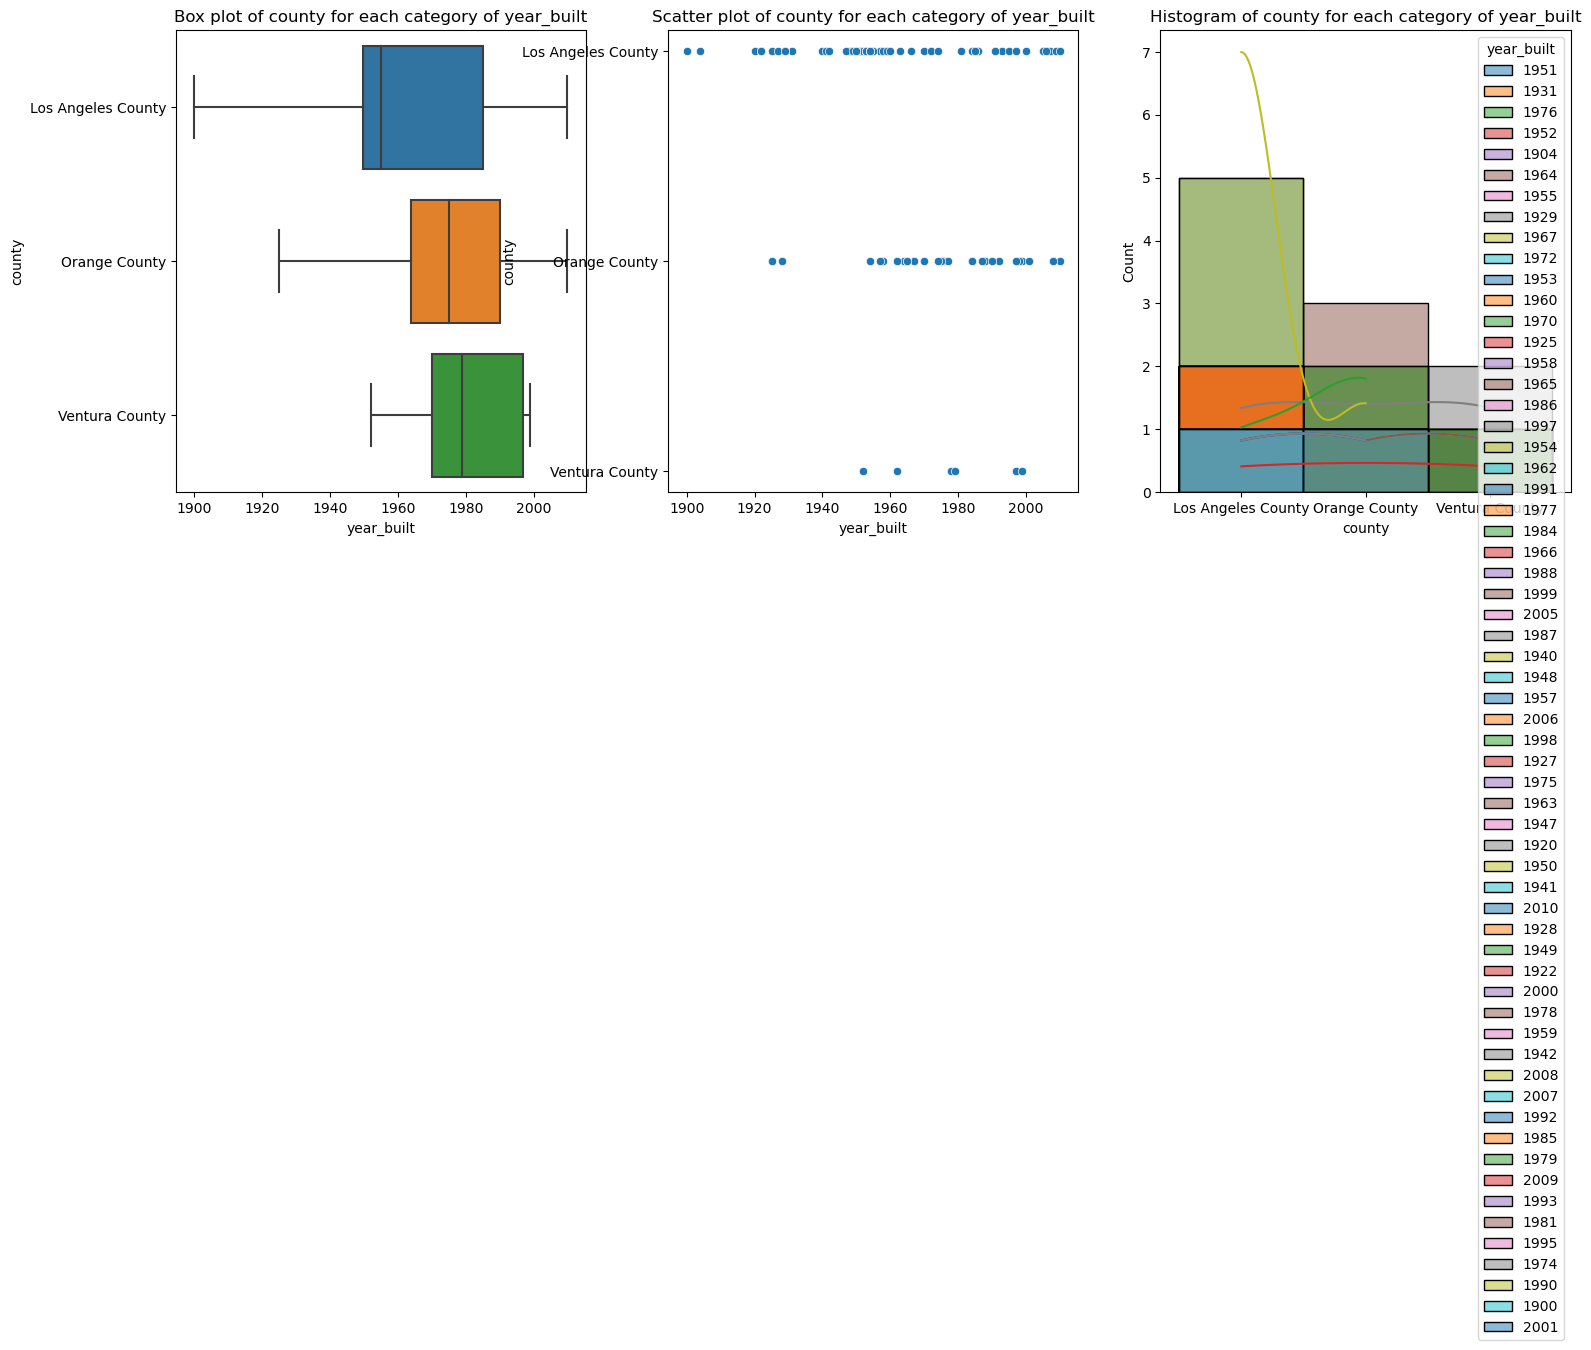

In [57]:
plot_categorical_and_continuous_vars(train, 'county', 'year_built', n=10)

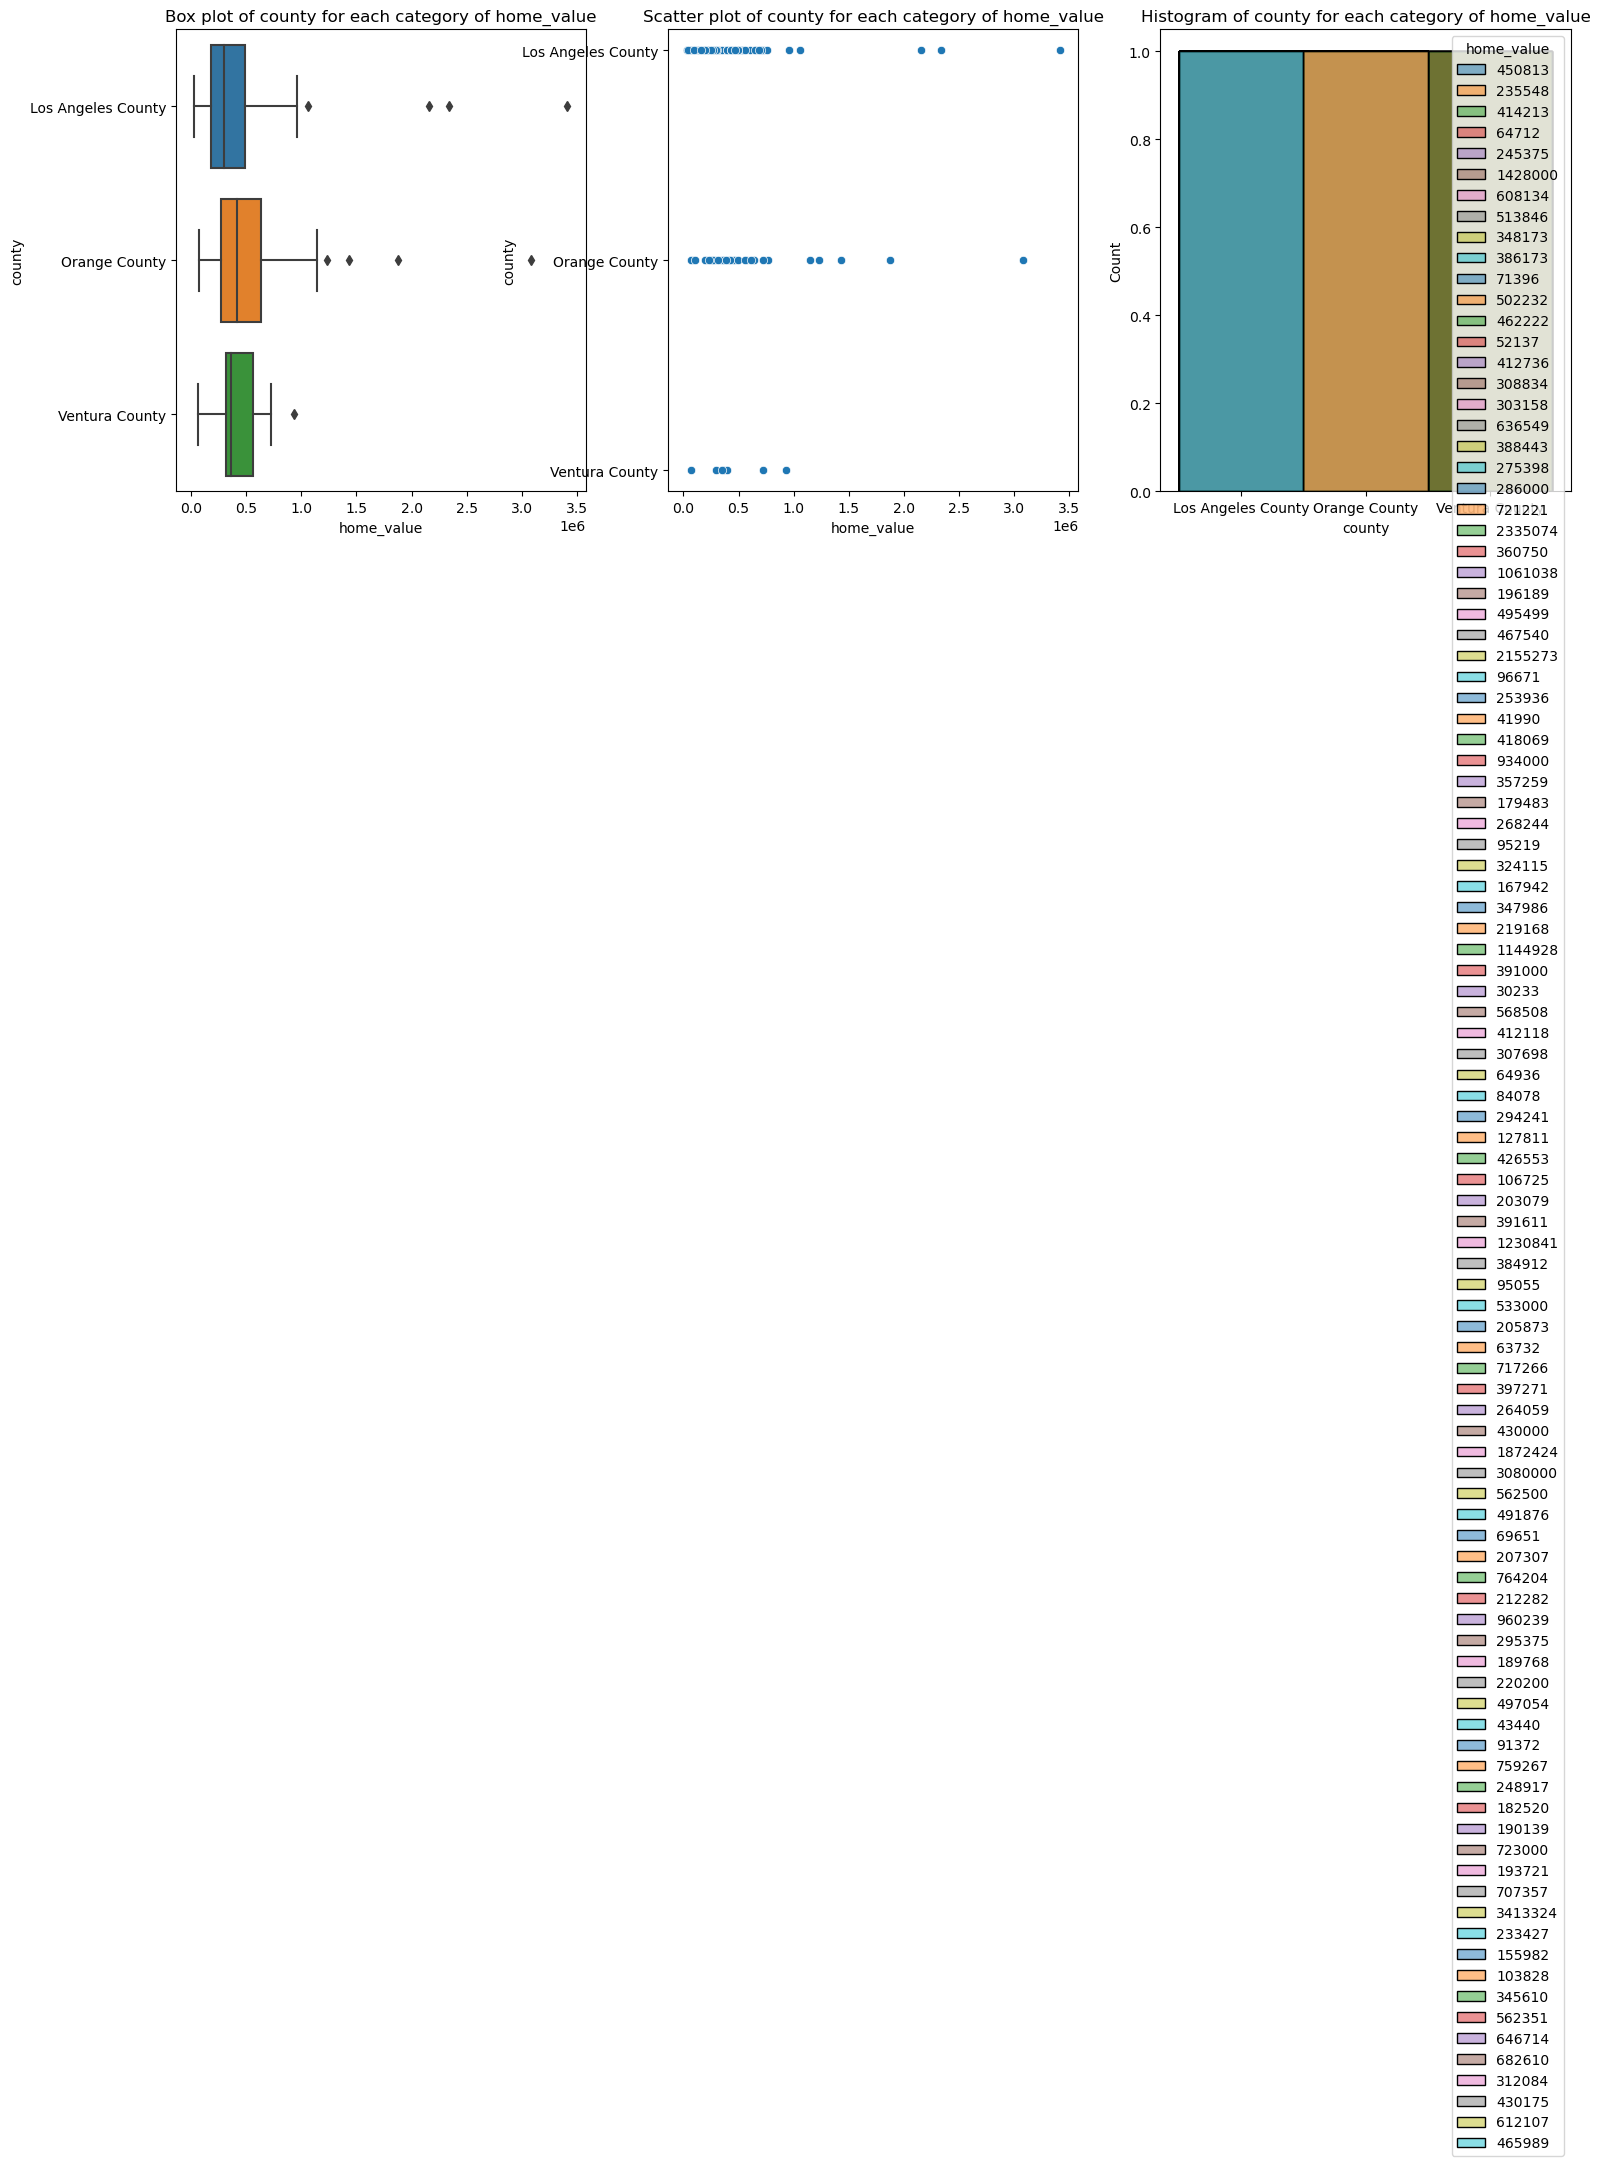

In [58]:
plot_categorical_and_continuous_vars(train, 'county', 'home_value', n=None)

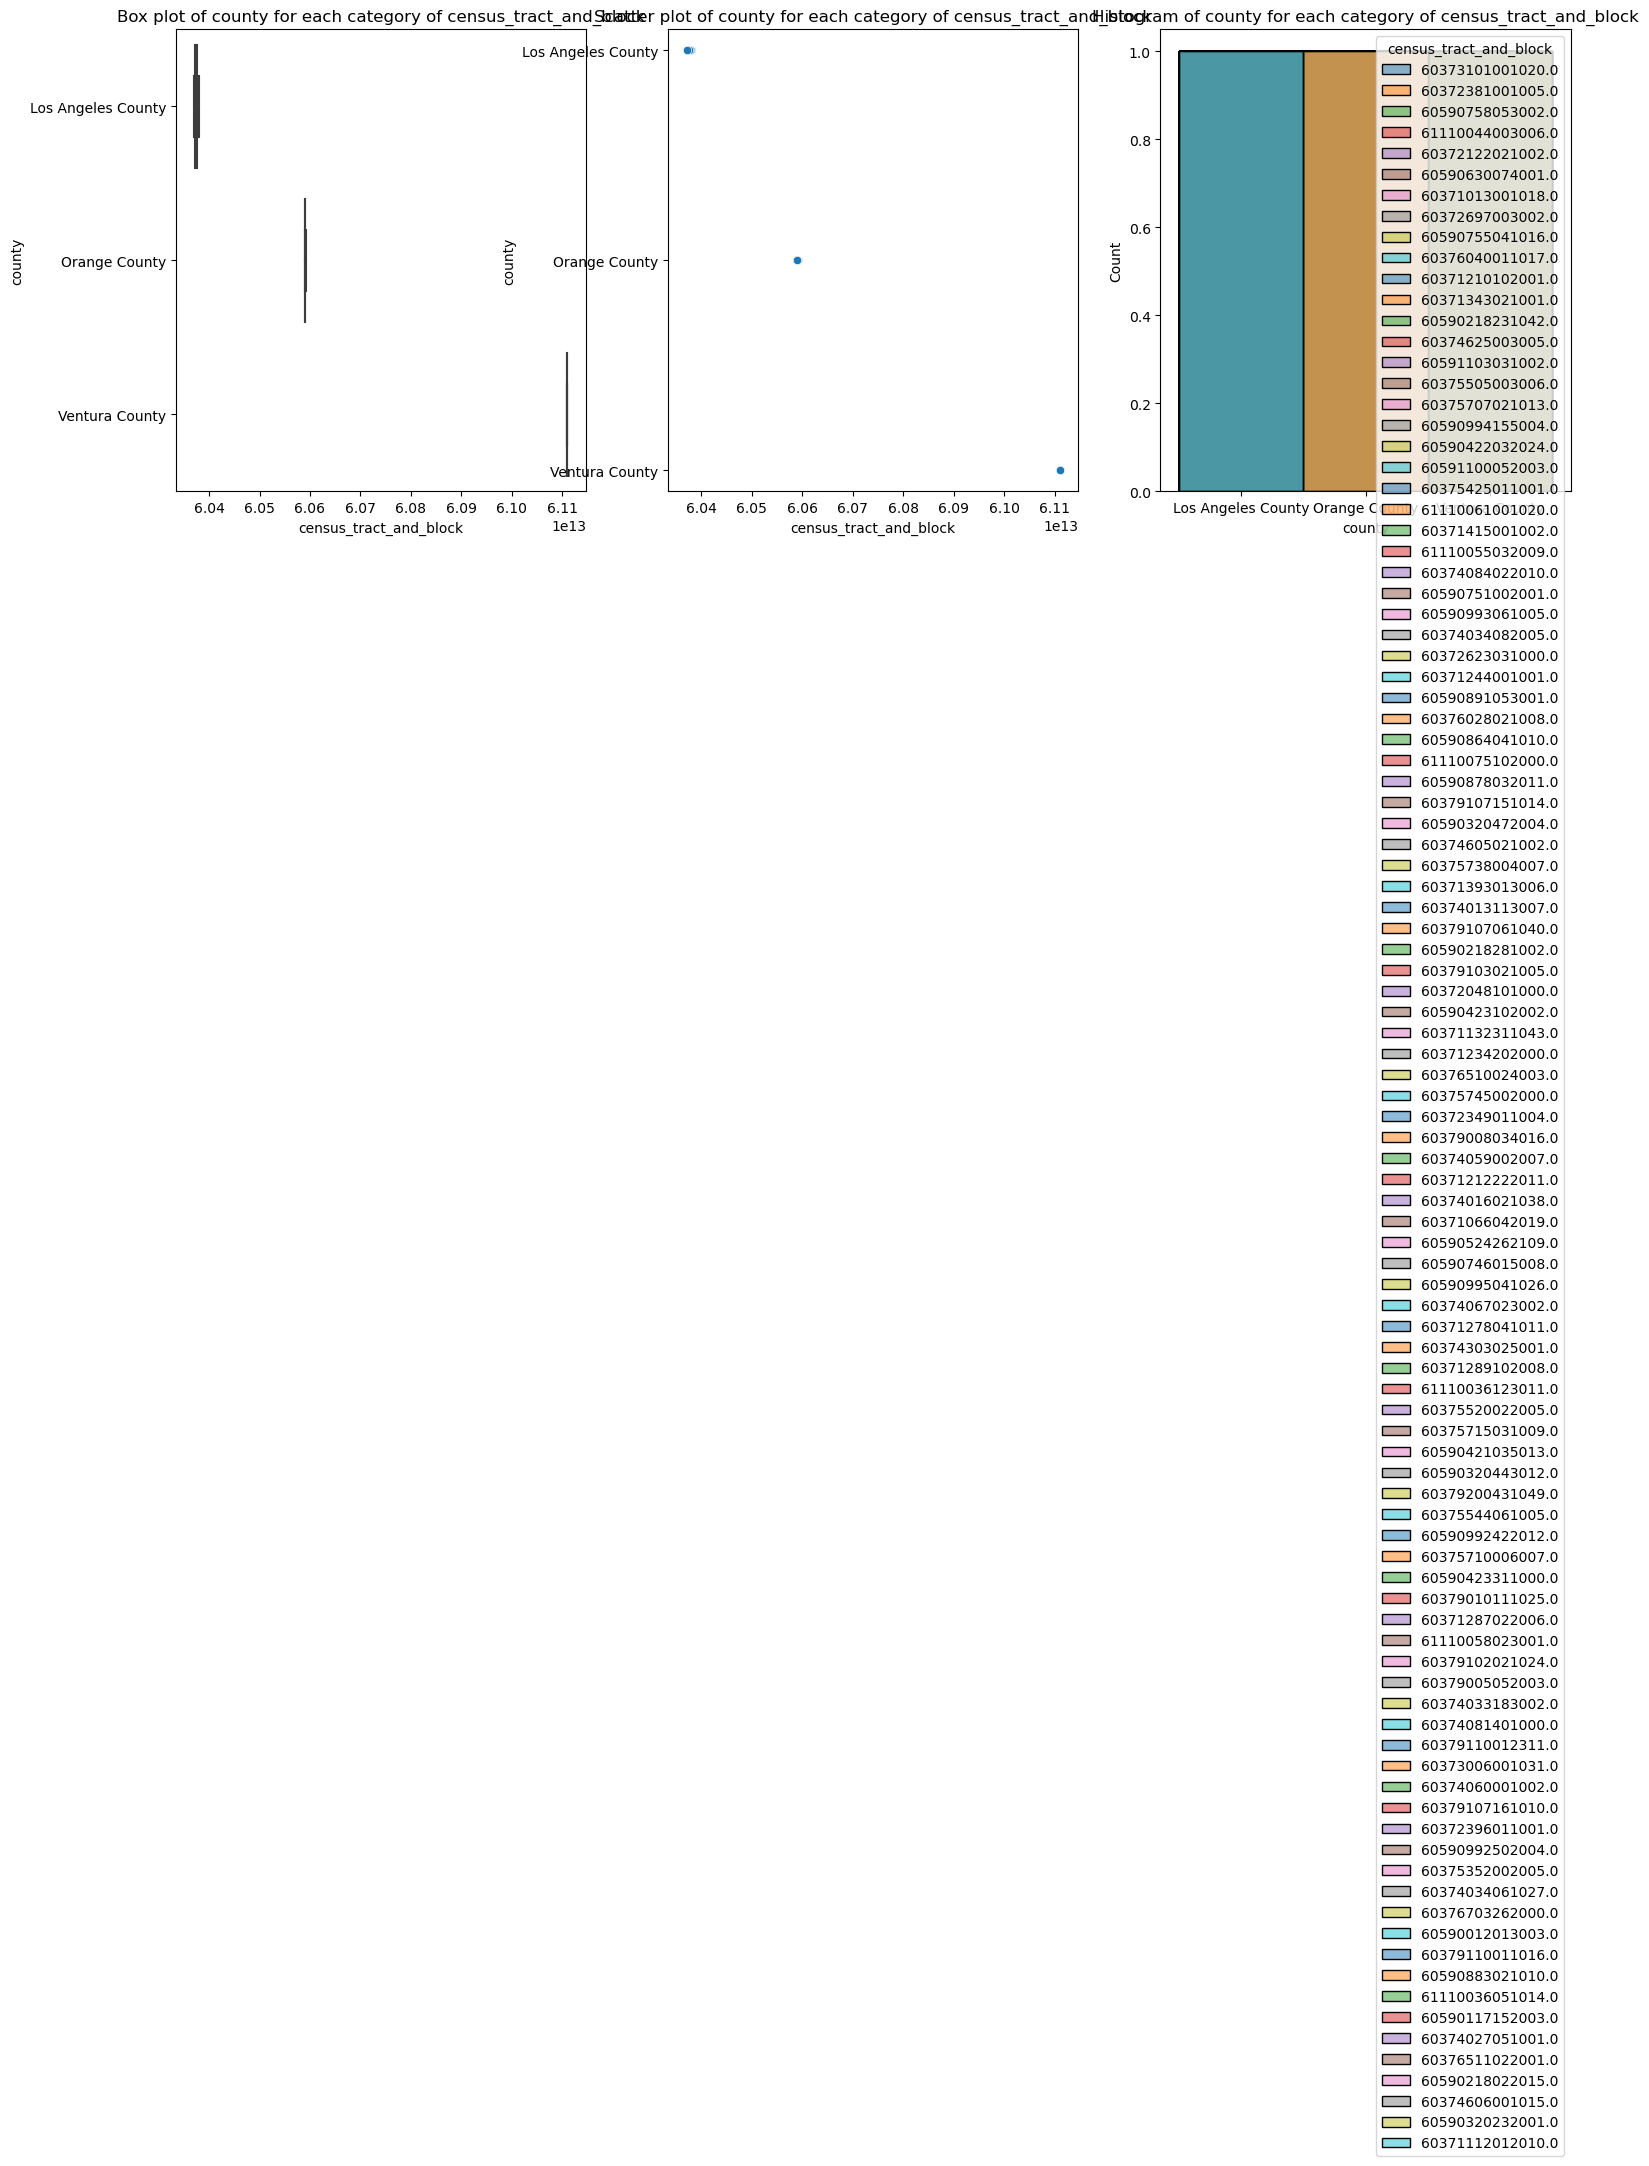

In [59]:
plot_categorical_and_continuous_vars(train, 'county', 'census_tract_and_block', n=None)

In [60]:
# def dist_of_nums():
    
#     for col in train.columns[train.dtypes != 'object']:

#         plt.figure()
#         sns.histplot(data = train, x = col)
#         plt.title(f'Distribution of {col}')
#         plt.show()

In [61]:
# def dist_of_objects():
    
#     for col in train.columns[train.dtypes == 'object']:
    
#         plt.figure()
#         sns.countplot(data = train, x = col)
#         plt.title(f'Count of {col}')
#         plt.show()

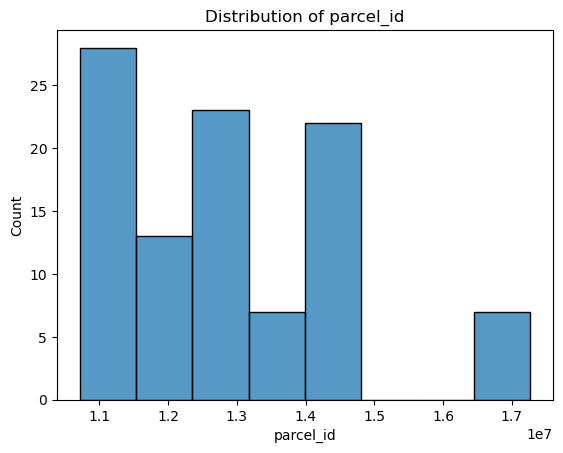

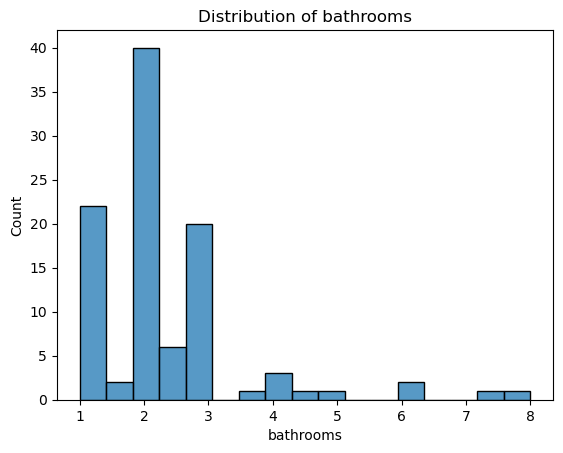

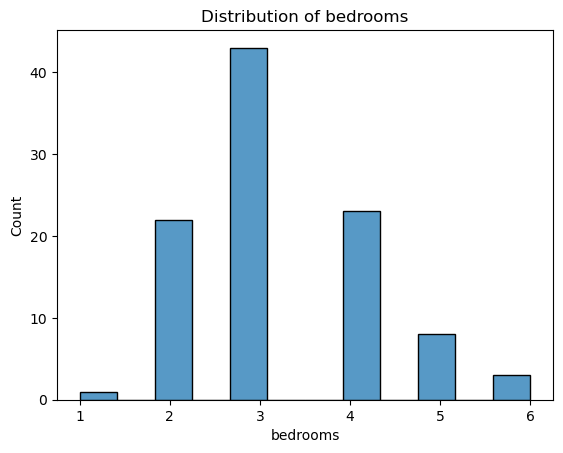

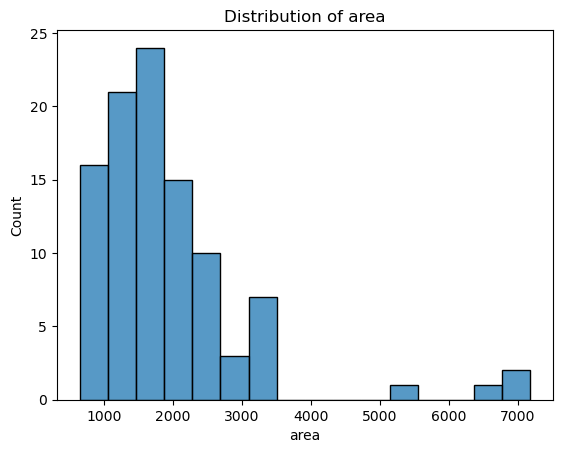

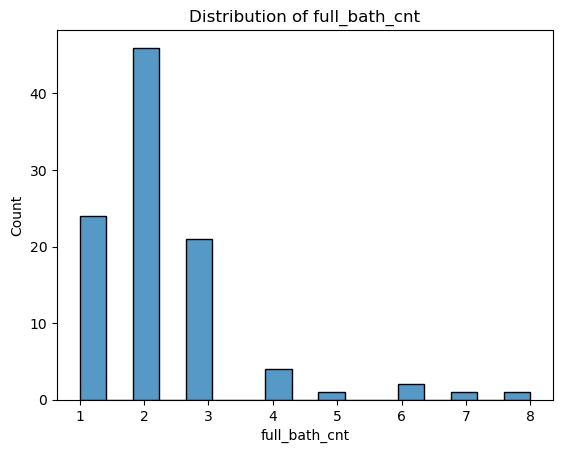

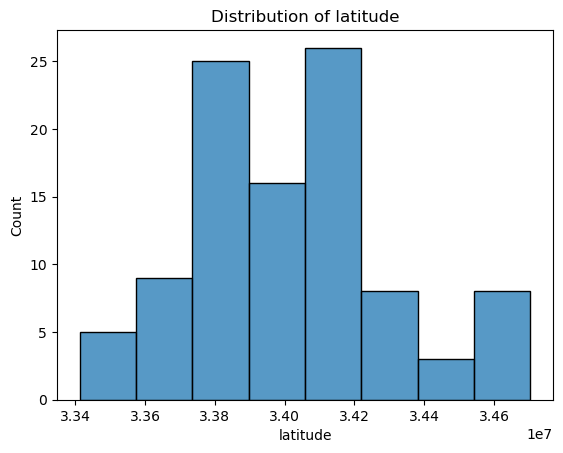

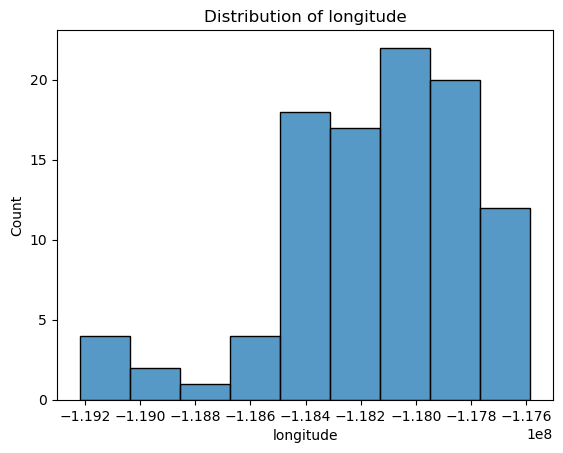

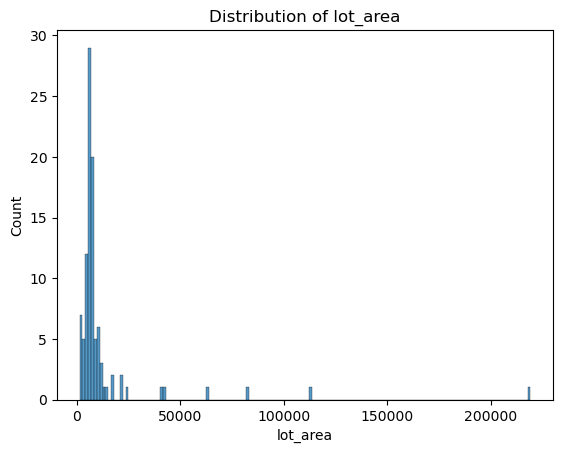

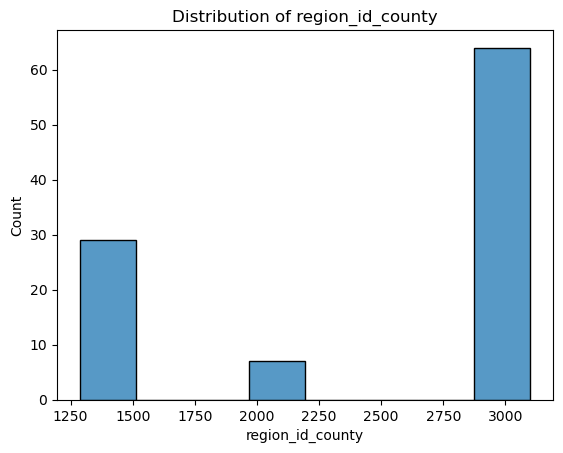

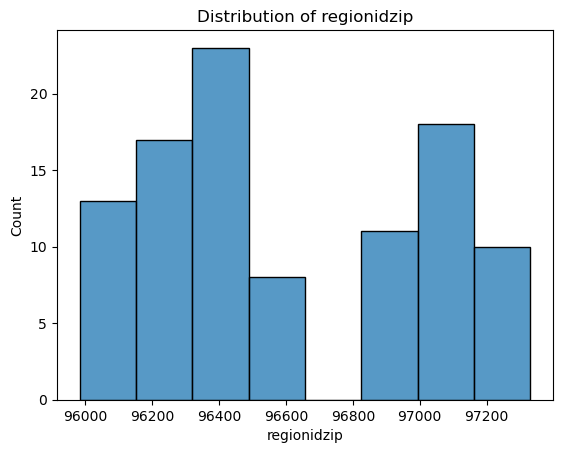

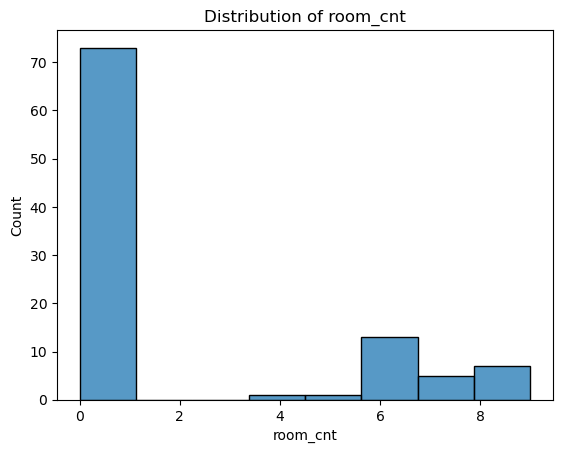

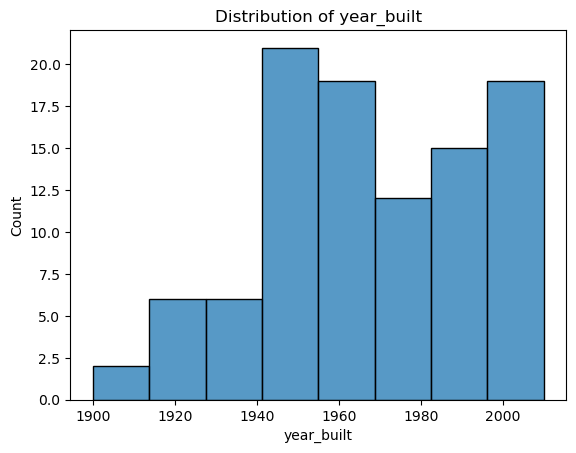

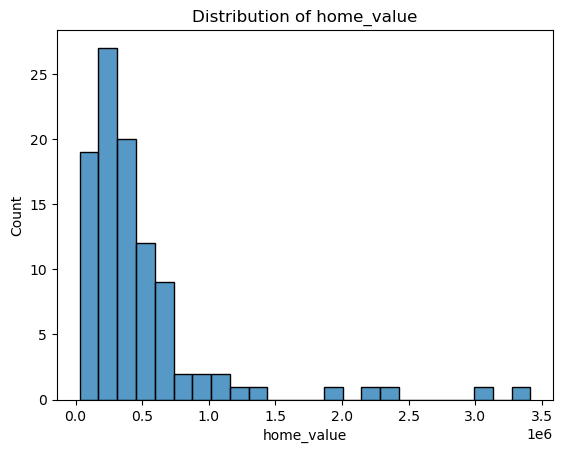

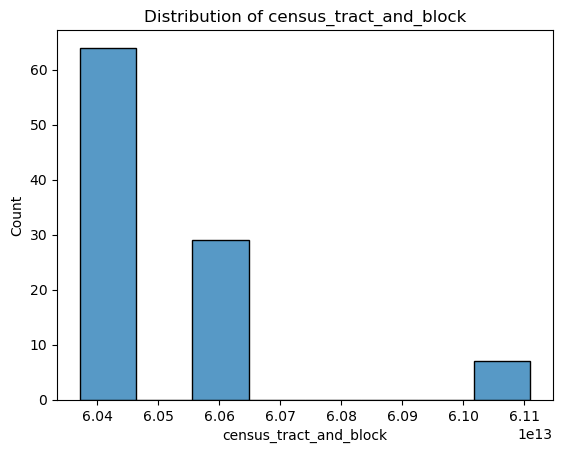

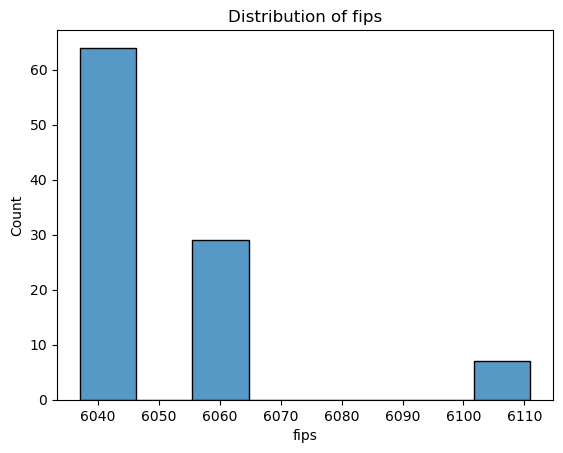

In [62]:
# called functions to see numerical data distributions
dist_of_nums(train)

In [63]:
# looking for object dtypes
train.dtypes == object

parcel_id                 False
bathrooms                 False
bedrooms                  False
area                      False
full_bath_cnt             False
latitude                  False
longitude                 False
lot_area                  False
region_id_county          False
regionidzip               False
room_cnt                  False
year_built                False
home_value                False
census_tract_and_block    False
fips                      False
state                      True
county                     True
dtype: bool

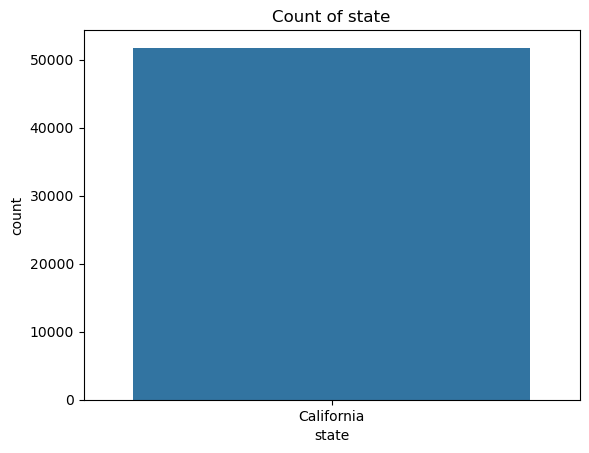

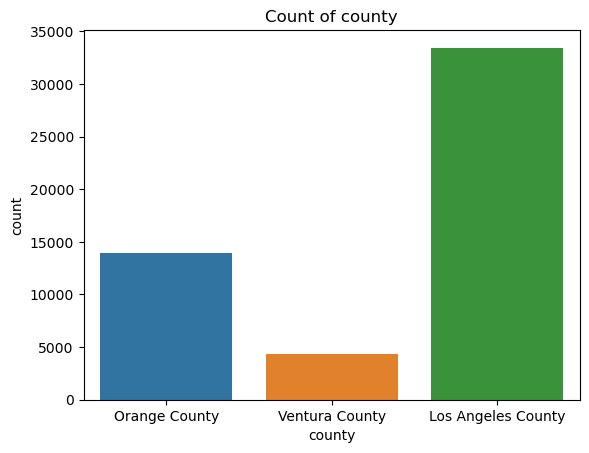

In [64]:
# dist_of_objects(df)

# visual for all object type variables distributions
for col in df.columns[df.dtypes == 'object']:

    plt.figure()
    sns.countplot(data = df, x = col)
    plt.title(f'Count of {col}')
    plt.show()

## EXPLORATION DONE!

takeaway: 

- The datset consist of alot of LA county homes,
- All counties are in the state of california.
- There is a right skew to quite a few dsitributions between categorical and continuous data.
- home value is on the lower range of the scale when they are all compared.
- larger homes exists in ventura county as well as the number of room_cnt and lot_area versus the other counties.
- most properties are listed with 0 in la county, i'm not entirely sure why, may be an issue
- the data is proportionate with home detail features versus geolocation and outside markers for single residential properties.

## Going to ask and answer 4 questions

## Question 1

* Does bedrooms have a relationship with home_value?
  
<!--bedrooms is categorical and home_value is continous-->

In [65]:
# taking a quick look at the bedrooms values
train.bedrooms.value_counts()

bedrooms
3    43
4    23
2    22
5     8
6     3
1     1
Name: count, dtype: int64

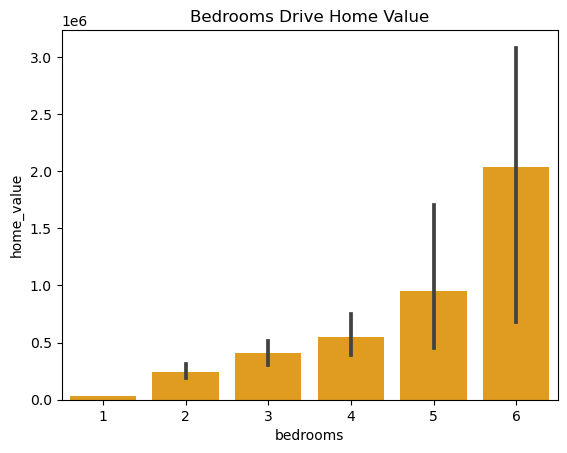

In [66]:
# visualizing bedrooms and home value
sns.barplot(data = train, x='bedrooms', y='home_value', color='orange').set(title='Bedrooms Drive Home Value')
plt.show()

**Takeaway:**  
bedrooms clearly have a relationship that appears linear. This will be a good feature to use to predict single family residential properties in the modeling phase.

## Question 2

* Does home_value have a correlation with year built?

home_value is continous and year_built is categorical

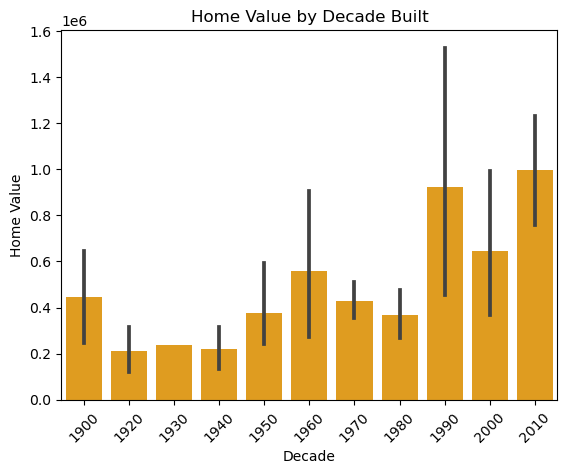

In [67]:
# new column 'decade' by binning 'year_built' values into decades
train['decade'] = (train['year_built'] // 10) * 10

# bar plot to visualize the relationship between 'decade' and 'tax_amount'
plt.figure()
sns.barplot(data=train, x='decade', y='home_value', color='orange')
plt.xlabel('Decade')
plt.ylabel('Home Value')
plt.title('Home Value by Decade Built')
plt.xticks(rotation=45)
plt.show()

# Question 3  

- Does home_value have a correlation with area?  
<!--homw_value and area is continous.-->

**Null Hypothesis($H0$):** There is **a significant correlation** between the area of the property and home value.  

**Alternative Hypothesis($Ha$):** There **is no significant correlation** between area of the property and home value.

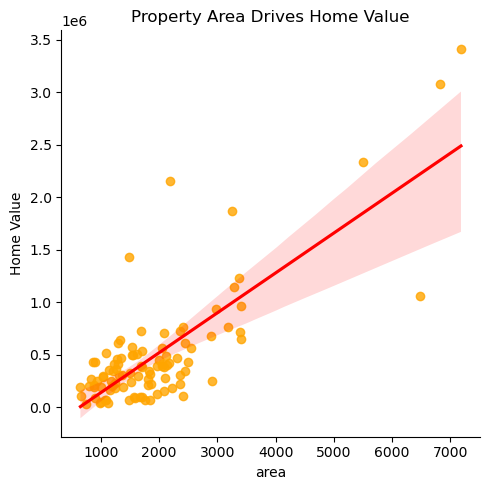

In [68]:
# a line plot with scattered data to see regression line and correlarion between varibales
sns.lmplot(data=train, x='area', y='home_value', scatter_kws={'color': 'orange'}, line_kws={'color': 'red'}).set(title='Property Area Drives Home Value')
plt.ylabel('Home Value')
plt.tight_layout()
plt.show()

In [69]:
#calling functino to evaluate the correlation with a stats test
correlation_coefficient, p_value, conclusion = evaluate_correlation(train.area, train.home_value, method="Pearson")
print(f'{conclusion}\n\np-value: {p_value}')

Reject the null hypothesis.

There is a significant linear correlation between area and home_value.

p-value: 3.1063922961841294e-22


# Question 4

- Does home_value have a correlation with the property lot area?  
<!--homw_value and area is continous.-->

**Null Hypothesis($H0$):** There is **a significant correlation** between the lot area of the property and home value.  

**Alternative Hypothesis($Ha$):** There **is no significant correlation** between lot area of the property and home value.

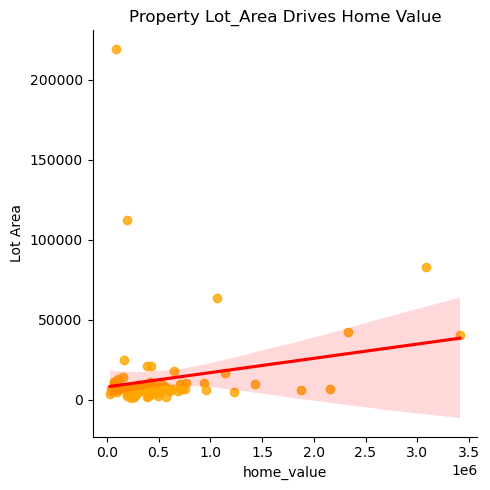

In [70]:
# a line plot with scattered data to see regression line and correlarion between varibales
sns.lmplot(data=train, x='home_value', y='lot_area', scatter_kws={'color': 'orange'}, line_kws={'color': 'red'}).set(title='Property Lot_Area Drives Home Value')
plt.ylabel('Lot Area')
plt.tight_layout()
plt.show()

In [71]:
# called function to evaluate and coduct a spearman's r stats test to this non-linear correlation between variables
correlation_coefficient, p_value, conclusion = evaluate_correlation(train.lot_area, train.home_value, method="Spearman")
print(f'{conclusion}\n\nCorrelation Coefficient: {correlation_coefficient:.4f}\n\np-value: {p_value}')

Fail to reject the null hypothesis.

There is no significant linear correlation between lot_area and home_value.

Correlation Coefficient: 0.1478

p-value: 0.14223449487847334


# MODEL EVALUATION PHASE

In [72]:
#re-reading data to get train subset out of sampled change
df = wrangle_zillow()

#have to drop categorical features becasue regression model only uses numerical features.
df = df.drop(columns=['county', 'state'])

train, val, test = train_val_test(df)

# checking shape of subset dfs
train.shape, val.shape, test.shape

((36212, 15), (7760, 15), (7760, 15))

In [73]:
# need to have the same shape before x, y split
train['decade'] = (train['year_built'] // 10) * 10
val['decade'] = (val['year_built'] // 10) * 10
test['decade'] = (test['year_built'] // 10) * 10

In [74]:
# checking shape of subset df
train.shape, val.shape, test.shape

((36212, 16), (7760, 16), (7760, 16))

In [75]:
#splitted subsets into x and y only for train and val, not doing test just yet
X_train, y_train = xy_split(train, 'home_value')
X_val, y_val = xy_split(val, 'home_value')

In [76]:
# checking mean to see if it is good for baseline, doesn't seem like it so far.
y_train.mean()

525764.2902905114

In [77]:
# The baseline will be median, assigned bl as y_train median value
bl = y_train.median()
bl

373565.5

In [78]:
# created a DF to work with
preds = pd.DataFrame({'y_actual' : y_train,
              'y_baseline': y_train.median()})

preds.head()

,y_actual,y_baseline
39762,432527,373565.5
48844,169135,373565.5
24439,163387,373565.5
48581,163308,373565.5
5570,461551,373565.5


In [79]:
# displating baseline resids
preds['y_baseline_residuals'] = preds['y_baseline'] - preds['y_actual']
preds.head()

,y_actual,y_baseline,y_baseline_residuals
39762,432527,373565.5,-58961.5
48844,169135,373565.5,204430.5
24439,163387,373565.5,210178.5
48581,163308,373565.5,210257.5
5570,461551,373565.5,-87985.5


In [80]:
# selecting model and fitting to train data, returning predictions and assigned as column y_hat
lm = LinearRegression()

lm.fit(X_train, y_train)

preds['y_hat'] = lm.predict(X_train)

In [81]:
lm

LinearRegression()

In [82]:
# y-hat resids calc
preds['y_hat_residuals'] = preds['y_hat'] - preds['y_actual']
preds.head()

,y_actual,y_baseline,y_baseline_residuals,y_hat,y_hat_residuals
39762,432527,373565.5,-58961.5,261823.684801,-170703.315199
48844,169135,373565.5,204430.5,439606.266411,270471.266411
24439,163387,373565.5,210178.5,505368.800075,341981.800075
48581,163308,373565.5,210257.5,176307.764809,12999.764809
5570,461551,373565.5,-87985.5,484700.668519,23149.668519


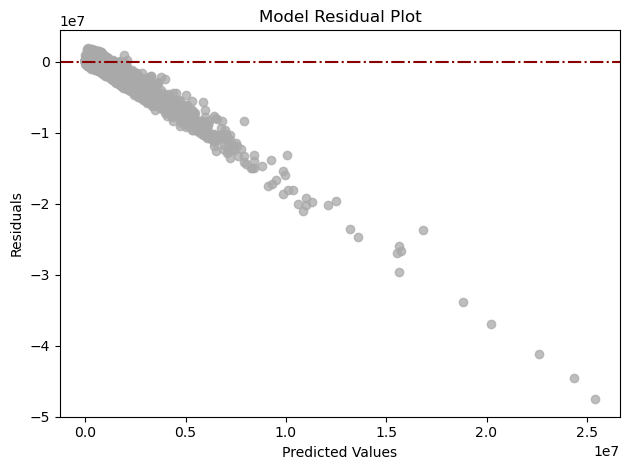


-------------------------------------

Model SSE: 10631435452132612.00

Model ESS: 7922608377375300.00

Model TSS: 18554045066387376.00

Model MSE: 293588739979.36

Model RMSE: 541838.30


-------------------------------------
Baseline SSE: 18554045066387376.00

Baseline MSE: 512372834043.61

Baseline RMSE: 715802.23


-------------------------------------

Is the model better than the baseline? True


In [83]:
# plot print statement for function output
plot_residuals(preds.y_actual, preds.y_hat_residuals)

print(f"\n-------------------------------------")


SSE, ESS, TSS, MSE, RMSE = regression_errors(preds.y_actual, preds.y_hat)

print(f"\nModel SSE: {SSE:.2f}\n")

print(f"Model ESS: {ESS:.2f}\n")

print(f"Model TSS: {TSS:.2f}\n")

print(f"Model MSE: {MSE:.2f}\n")

print(f"Model RMSE: {RMSE:.2f}\n")

print(f"\n-------------------------------------")

SSE_baseline, MSE_baseline, RMSE_baseline = baseline_mean_errors(preds.y_actual)

print(f"Baseline SSE: {SSE_baseline:.2f}\n")

print(f"Baseline MSE: {MSE_baseline:.2f}\n")

print(f"Baseline RMSE: {RMSE_baseline:.2f}\n")

print(f"\n-------------------------------------")

print(f"\nIs the model better than the baseline? {better_than_baseline(preds.y_actual, preds.y_hat)}")

## EVALUATION ROUND 2 NO DECADES COLUMNS

In [84]:
#re-reading data to get train subset out of sampled change
df2 = wrangle_zillow()
df2.head()

,parcel_id,bathrooms,bedrooms,area,full_bath_cnt,latitude,longitude,lot_area,region_id_county,regionidzip,room_cnt,year_built,home_value,census_tract_and_block,fips,state,county
0,14297519,3.5,4,3100,3,33634931.0,-117869207.0,4506,1286,96978,0,1998,1023282,6.059063e+13,6059,California,Orange County
1,17052889,1.0,2,1465,1,34449266.0,-119281531.0,12647,2061,97099,5,1967,464000,6.111001e+13,6111,California,Ventura County
2,14186244,2.0,3,1243,2,33886168.0,-117823170.0,8432,1286,97078,6,1962,564778,6.059022e+13,6059,California,Orange County
3,12177905,3.0,4,2376,3,34245180.0,-118240722.0,13038,3101,96330,0,1970,145143,6.037300e+13,6037,California,Los Angeles County
4,12095076,3.0,4,2962,3,34145202.0,-118179824.0,63000,3101,96293,0,1950,773303,6.037461e+13,6037,California,Los Angeles County


In [85]:
#have to drop categorical features becasue regression model only uses numerical features.
df2 = df2.drop(columns=['parcel_id', 'latitude', 'longitude', 'state', 'county', 'region_id_county', 'regionidzip', 'census_tract_and_block', 'fips', 'room_cnt'])

In [86]:
train2, val2, test2 = train_val_test(df)

# checking shape of subset dfs
train2.shape, val2.shape, test2.shape

((36212, 15), (7760, 15), (7760, 15))

In [87]:
# checking shape of subset df\
train2.shape, val2.shape, test2.shape

((36212, 15), (7760, 15), (7760, 15))

In [88]:
#splitted subsets into x and y only for train and val, not doing test just yet
X_train2, y_train2 = xy_split(train2, 'home_value')
X_val2, y_val2 = xy_split(val2, 'home_value')

In [89]:
# checking mean to see if it is good for baseline, doesn't seem like it so far.
y_train2.mean()

525764.2902905114

In [90]:
# The baseline will be median, assigned bl as y_train median value
bl = y_train2.median()
bl

373565.5

In [91]:
# created a DF to work with
preds2 = pd.DataFrame({'y_actual2' : y_train2,
              'y_baseline2': y_train2.median()})

preds2.head()

,y_actual2,y_baseline2
39762,432527,373565.5
48844,169135,373565.5
24439,163387,373565.5
48581,163308,373565.5
5570,461551,373565.5


In [92]:
# baseline resids calc fro seconf round of testing
preds2['y_baseline_residuals2'] = preds2['y_baseline2'] - preds2['y_actual2']
preds2.head()

,y_actual2,y_baseline2,y_baseline_residuals2
39762,432527,373565.5,-58961.5
48844,169135,373565.5,204430.5
24439,163387,373565.5,210178.5
48581,163308,373565.5,210257.5
5570,461551,373565.5,-87985.5


In [93]:
# fitting model again and y_hat2 for second set of predictions
lm = LinearRegression()

lm.fit(X_train2, y_train2)

preds2['y_hat2'] = lm.predict(X_train2)

In [94]:
lm

LinearRegression()

In [95]:
# y-hat-resdiuals calculation
preds2['y_hat_residuals2'] = preds2['y_hat2'] - preds2['y_actual2']
preds2.head()

,y_actual2,y_baseline2,y_baseline_residuals2,y_hat2,y_hat_residuals2
39762,432527,373565.5,-58961.5,257442.488027,-175084.511973
48844,169135,373565.5,204430.5,439201.366632,270066.366632
24439,163387,373565.5,210178.5,510337.589396,346950.589396
48581,163308,373565.5,210257.5,176073.146534,12765.146534
5570,461551,373565.5,-87985.5,488954.019043,27403.019043


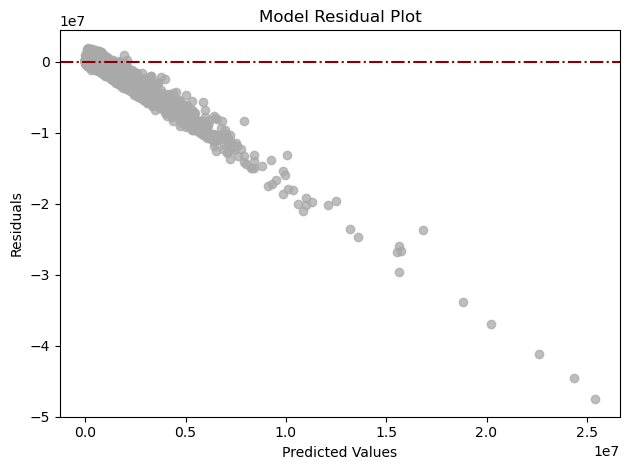


-------------------------------------

Model SSE: 10631917567916976.00

Model ESS: 7922129221203512.00

Model TSS: 18554045066387376.00

Model MSE: 293602053681.57

Model RMSE: 541850.58


-------------------------------------
Baseline SSE: 18554045066387376.00

Baseline MSE: 512372834043.61

Baseline RMSE: 715802.23


-------------------------------------

Is the model better than the baseline? True


In [96]:
#print statement for plot function
plot_residuals(preds2.y_actual2, preds2.y_hat_residuals2)

print(f"\n-------------------------------------")


SSE, ESS, TSS, MSE, RMSE = regression_errors(preds2.y_actual2, preds2.y_hat2)

print(f"\nModel SSE: {SSE:.2f}\n")

print(f"Model ESS: {ESS:.2f}\n")

print(f"Model TSS: {TSS:.2f}\n")

print(f"Model MSE: {MSE:.2f}\n")

print(f"Model RMSE: {RMSE:.2f}\n")

print(f"\n-------------------------------------")

SSE_baseline, MSE_baseline, RMSE_baseline = baseline_mean_errors(preds2.y_actual2)

print(f"Baseline SSE: {SSE_baseline:.2f}\n")

print(f"Baseline MSE: {MSE_baseline:.2f}\n")

print(f"Baseline RMSE: {RMSE_baseline:.2f}\n")

print(f"\n-------------------------------------")

print(f"\nIs the model better than the baseline? {better_than_baseline(preds2.y_actual2, preds2.y_hat2)}")

### Current model is doing a bit better than the baseline

In [97]:
# checking current data frame features
df.head()

,parcel_id,bathrooms,bedrooms,area,full_bath_cnt,latitude,longitude,lot_area,region_id_county,regionidzip,room_cnt,year_built,home_value,census_tract_and_block,fips
0,14297519,3.5,4,3100,3,33634931.0,-117869207.0,4506,1286,96978,0,1998,1023282,6.059063e+13,6059
1,17052889,1.0,2,1465,1,34449266.0,-119281531.0,12647,2061,97099,5,1967,464000,6.111001e+13,6111
2,14186244,2.0,3,1243,2,33886168.0,-117823170.0,8432,1286,97078,6,1962,564778,6.059022e+13,6059
3,12177905,3.0,4,2376,3,34245180.0,-118240722.0,13038,3101,96330,0,1970,145143,6.037300e+13,6037
4,12095076,3.0,4,2962,3,34145202.0,-118179824.0,63000,3101,96293,0,1950,773303,6.037461e+13,6037


In [98]:
# cehcking second df for feature organization
df2.head()

,bathrooms,bedrooms,area,full_bath_cnt,lot_area,year_built,home_value
0,3.5,4,3100,3,4506,1998,1023282
1,1.0,2,1465,1,12647,1967,464000
2,2.0,3,1243,2,8432,1962,564778
3,3.0,4,2376,3,13038,1970,145143
4,3.0,4,2962,3,63000,1950,773303


In [99]:
# checking y_train array
y_train.head()

39762    432527
48844    169135
24439    163387
48581    163308
5570     461551
Name: home_value, dtype: int32

In [100]:
# checking secind y-train array
y_train2.head()

39762    432527
48844    169135
24439    163387
48581    163308
5570     461551
Name: home_value, dtype: int32

### Calculate Model Significance

In [101]:
# calculating model significance
r2_score(preds['y_actual'], preds['y_hat'])

0.42700174468194074

In [102]:
# calc model significance
explained_variance_score(preds['y_actual'], preds['y_hat'])

0.42700174468194063

# Training and Evaluating different models

In [103]:
# displaying df
train.head()

,parcel_id,bathrooms,bedrooms,area,full_bath_cnt,latitude,longitude,lot_area,region_id_county,regionidzip,room_cnt,year_built,home_value,census_tract_and_block,fips,decade
39762,12115385,2.0,3,1218,2,34164673.0,-118126949.0,9251,3101,96292,0,1921,432527,6.037462e+13,6037,1920
48844,12825439,2.0,3,1662,2,33931418.0,-118001601.0,6455,3101,96172,0,1954,169135,6.037504e+13,6037,1950
24439,12668213,1.0,3,1580,1,33821835.0,-118387104.0,7509,3101,96123,0,1948,163387,6.037621e+13,6037,1940
48581,12266229,1.0,3,1079,1,33906624.0,-118240829.0,6249,3101,96092,0,1954,163308,6.037541e+13,6037,1950
5570,14379497,3.0,4,1986,3,33611735.0,-117688925.0,7560,1286,96995,8,1968,461551,6.059032e+13,6059,1960


In [104]:
# checking for train subset sha[pe
train.shape

(36212, 16)

In [105]:
# setting up scaled features and checking them 
to_scale = ['parcel_id', 'bathrooms', 'bedrooms', 'area', 'full_bath_cnt', 'latitude', 'longitude', 'lot_area',	'region_id_county', 'regionidzip', 'room_cnt', 'year_built', 'census_tract_and_block', 'fips']
train, val, test = scale_data(train, val, test, to_scale)
train.head()

,parcel_id,bathrooms,bedrooms,area,full_bath_cnt,latitude,longitude,lot_area,region_id_county,regionidzip,room_cnt,year_built,home_value,census_tract_and_block,fips,decade
39762,0.009219,0.1,0.272727,0.048951,0.1,0.559834,0.702287,0.001293,1.0,0.001021,0.000000,0.311594,432527,0.000009,0.000000,1920
48844,0.013882,0.1,0.272727,0.069339,0.1,0.401324,0.767577,0.000892,1.0,0.000626,0.000000,0.550725,169135,0.000010,0.000000,1950
24439,0.012850,0.0,0.272727,0.065574,0.0,0.326856,0.566782,0.001043,1.0,0.000464,0.000000,0.507246,163387,0.000012,0.000000,1940
48581,0.010209,0.0,0.272727,0.042568,0.0,0.384475,0.642972,0.000863,1.0,0.000362,0.000000,0.550725,163308,0.000010,0.000000,1950
5570,0.024090,0.2,0.363636,0.084217,0.2,0.184081,0.930438,0.001051,0.0,0.003336,0.533333,0.652174,461551,0.000519,0.297297,1960


In [106]:
# checked for shape again
train.shape

(36212, 16)

In [107]:
# splitted subsets into x and y only for train and val, not doing test just yet
X_train, y_train = xy_split(train, 'home_value')
X_val, y_val = xy_split(val, 'home_value')

In [108]:
# checking both sets match shape
X_train.shape, X_val.shape

((36212, 15), (7760, 15))

In [109]:
# checking X_train subset df
X_train.head()

,parcel_id,bathrooms,bedrooms,area,full_bath_cnt,latitude,longitude,lot_area,region_id_county,regionidzip,room_cnt,year_built,census_tract_and_block,fips,decade
39762,0.009219,0.1,0.272727,0.048951,0.1,0.559834,0.702287,0.001293,1.0,0.001021,0.000000,0.311594,0.000009,0.000000,1920
48844,0.013882,0.1,0.272727,0.069339,0.1,0.401324,0.767577,0.000892,1.0,0.000626,0.000000,0.550725,0.000010,0.000000,1950
24439,0.012850,0.0,0.272727,0.065574,0.0,0.326856,0.566782,0.001043,1.0,0.000464,0.000000,0.507246,0.000012,0.000000,1940
48581,0.010209,0.0,0.272727,0.042568,0.0,0.384475,0.642972,0.000863,1.0,0.000362,0.000000,0.550725,0.000010,0.000000,1950
5570,0.024090,0.2,0.363636,0.084217,0.2,0.184081,0.930438,0.001051,0.0,0.003336,0.533333,0.652174,0.000519,0.297297,1960


In [110]:
# creating df for y_train mean, median, and actuals
y_train.mean(), y_train.median()
bl = pd.DataFrame({"y_actual" : y_train,
                   "y_mean" : y_train.mean(),
                   "y_median" : y_train.median()})
bl.head()

,y_actual,y_mean,y_median
39762,432527,525764.290291,373565.5
48844,169135,525764.290291,373565.5
24439,163387,525764.290291,373565.5
48581,163308,525764.290291,373565.5
5570,461551,525764.290291,373565.5


In [111]:
# calling evaluate model function on mean
eval_model(bl.y_actual, bl.y_mean)

715802.23109712

In [112]:
# callifn eval_model function on median
eval_model(bl.y_actual, bl.y_median)

731804.144433133

In [113]:
# now that i have established scaled baselines i'm going to try to train w/ wach ml technique

In [114]:
# training and evaulating function w/ LinearRegression algorithm and outputting rmse values for train and validation.
lm = LinearRegression()
trained_model, train_rmse, val_rmse = train_and_evaluate_model(lm, X_train, y_train, X_val, y_val)

The train RMSE is 541838.30.

The validation RMSE is 504322.70.




In [115]:
# training and evaulating function w/ LassoLars algorithm and outputting rmse values for train and validation.

ll = LassoLars(alpha=0)
trained_model, train_rmse, val_rmse = train_and_evaluate_model(ll, X_train, y_train, X_val, y_val)

The train RMSE is 541838.30.

The validation RMSE is 504322.70.




In [116]:
# training and evaulating function w/ LassoLars algorithm and outputting rmse values for train and validation.
# alpha set at 0.5
ll = LassoLars(alpha=0.5)
trained_model, train_rmse, val_rmse = train_and_evaluate_model(ll, X_train, y_train, X_val, y_val)

The train RMSE is 541838.31.

The validation RMSE is 504322.59.




In [117]:
# generating polynomial features and fit transform on train data

poly = PolynomialFeatures()
X_train_s = poly.fit_transform(X_train)
X_val_s = poly.transform(X_val)

In [118]:
# checking on length of df
len(X_train_s[0])

136

In [119]:
# looking at shape of fit df
X_train_s.shape

(36212, 136)

In [120]:
# training and evaulating function w/ LinearRegression algorithm and outputting rmse values for train and validation. (poly)
lm = LinearRegression()
trained_model, train_rmse, val_rmse = train_and_evaluate_model(lm, X_train, y_train, X_val, y_val)

The train RMSE is 541838.30.

The validation RMSE is 504322.70.




In [121]:
# tested tweddie regressor algorithm: did not perform well actually it did the worst.
tweedie = TweedieRegressor()
trained_model, train_rmse, val_rmse = train_and_evaluate_model(tweedie, X_train, y_train, X_val, y_val)

The train RMSE is 699804.39.

The validation RMSE is 671596.85.




In [122]:
# RFR did great, but it is heavily over fit i need to tune parameters
rfr = RandomForestRegressor()
trained_model, train_rmse, val_rmse = train_and_evaluate_model(rfr, X_train, y_train, X_val, y_val)

The train RMSE is 172688.67.

The validation RMSE is 468673.76.




In [123]:
# # experimental code that can be a function for customizing hyperparameters to improve model and find best result
# # i need to feature engineer data ( imputations, fill in,  and maybe other methods as well)
# from sklearn.model_selection import GridSearchCV
# from sklearn.ensemble import RandomForestRegressor

# # Define the hyperparameters and their ranges
# param_grid = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [None, 10, 20, 30],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'max_features': ['auto', 'sqrt', 'log2'],
#     # Add other hyperparameters and their ranges
# }

# # Create the Random Forest Regressor
# rfr = RandomForestRegressor()

# # Create a GridSearchCV object
# grid_search = GridSearchCV(rfr, param_grid, cv=5, scoring='neg_mean_squared_error')

# # Fit the grid search to your training data
# grid_search.fit(X_train, y_train)

# # Get the best hyperparameters
# best_params = grid_search.best_params_

# # Rebuild the model with the best hyperparameters and train it on the entire training dataset
# best_rfrmodel = RandomForestRegressor(**best_params)
# best_rfrmodel.fit(X_train, y_train)

# # Predict on training and validation data
# train_preds = best_rfrmodel.predict(X_train)
# val_preds = best_rfrmodel.predict(X_val)
    
# # Evaluate the model's performance
# train_rmse = eval_model(y_train, train_preds)
# val_rmse = eval_model(y_val, val_preds)

In [124]:
# # Print the results
# print(f'The train RMSE is {train_rmse:.2f}.\n')
# print(f'The validation RMSE is {val_rmse:.2f}.\n\n')

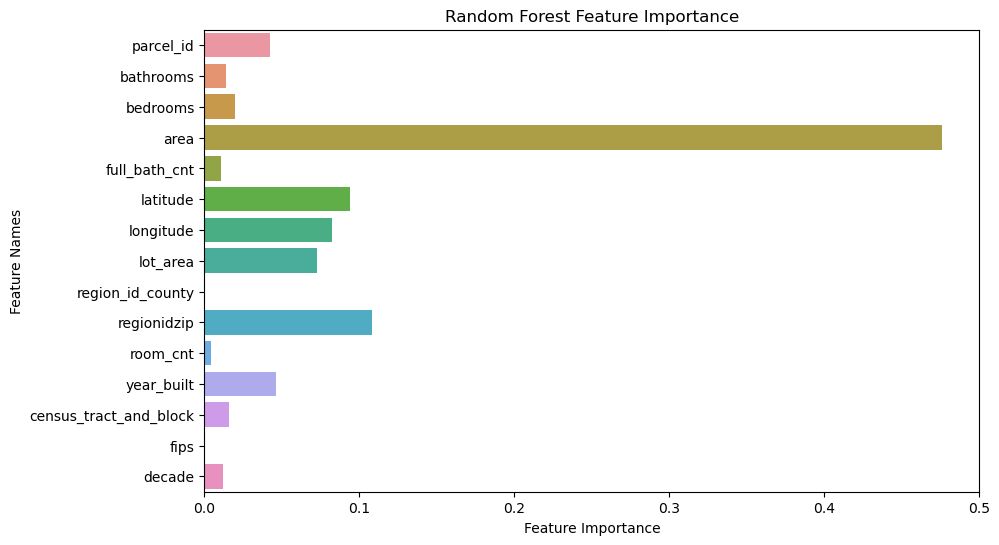

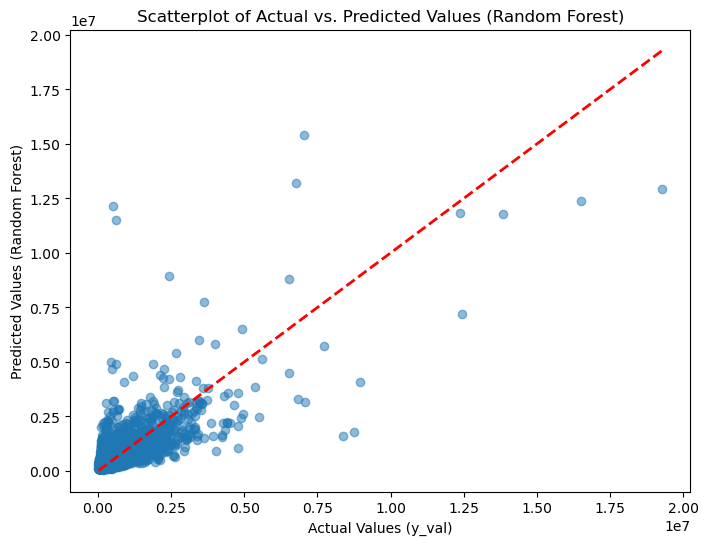

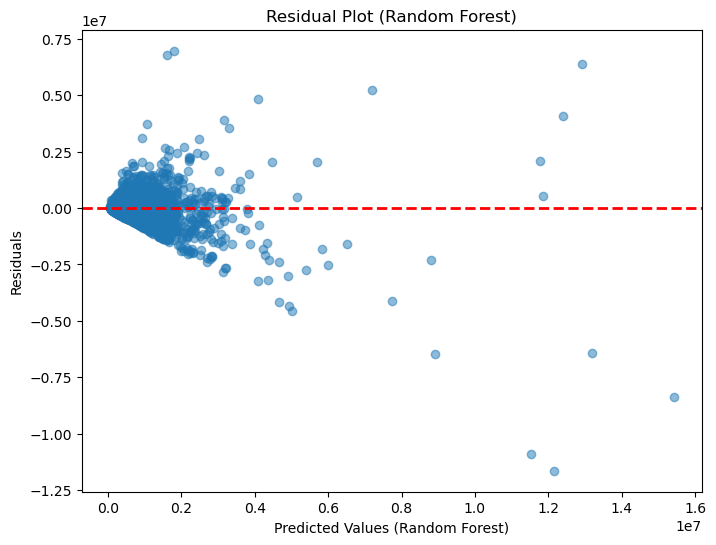

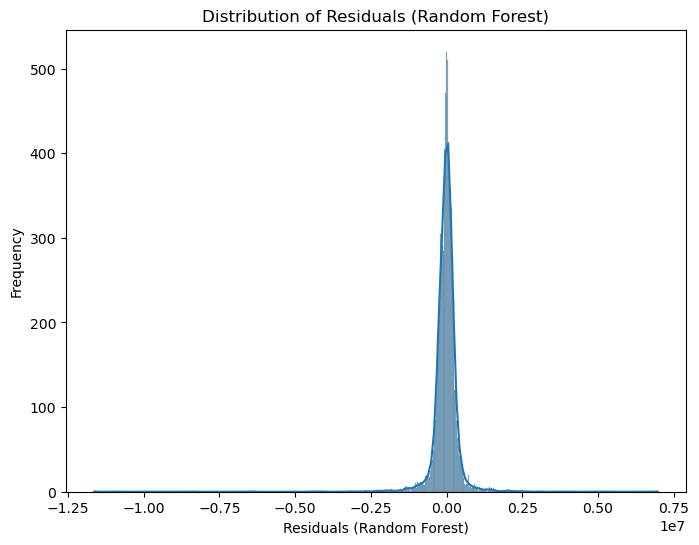

In [125]:
from sklearn.ensemble import RandomForestRegressor

# Assuming you have trained your Random Forest Regression model (rf_model) using your train_and_evaluate_model function

feature_names = X_train.columns.to_list()

# Feature Importance Plot
feature_importance = trained_model.feature_importances_
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance, y=feature_names)
plt.xlabel("Feature Importance")
plt.ylabel("Feature Names")
plt.title("Random Forest Feature Importance")
plt.show()

# Scatterplot of Actual vs. Predicted Values
predicted_val_rf = trained_model.predict(X_val)
plt.figure(figsize=(8, 6))
plt.scatter(y_val, predicted_val_rf, alpha=0.5)
plt.xlabel("Actual Values (y_val)")
plt.ylabel("Predicted Values (Random Forest)")
plt.title("Scatterplot of Actual vs. Predicted Values (Random Forest)")
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], linestyle='--', color='red', lw=2)
plt.show()

# Residual Plot
residuals_rf = y_val - predicted_val_rf
plt.figure(figsize=(8, 6))
plt.scatter(predicted_val_rf, residuals_rf, alpha=0.5)
plt.xlabel("Predicted Values (Random Forest)")
plt.ylabel("Residuals")
plt.title("Residual Plot (Random Forest)")
plt.axhline(y=0, color='red', linestyle='--', lw=2)
plt.show()

# Distribution of Residuals (Random Forest)
plt.figure(figsize=(8, 6))
sns.histplot(residuals_rf, kde=True)
plt.xlabel("Residuals (Random Forest)")
plt.ylabel("Frequency")
plt.title("Distribution of Residuals (Random Forest)")
plt.show()


In [126]:
# training and evaulating function w/ XGBoostRegressor algorithm and outputting rmse values for train and validation.
xgboost = XGBRegressor()
trained_model, train_rmse, val_rmse = train_and_evaluate_model(xgboost, X_train, y_train, X_val, y_val)

The train RMSE is 242414.13.

The validation RMSE is 471969.82.




In [127]:
# hyper parameters edit
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

# Define the hyperparameters and their ranges
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    # Add other hyperparameters and their ranges
}

# Create the XGBoost regressor
xgb = XGBRegressor()

# Create a GridSearchCV object
grid_search = GridSearchCV(xgb, param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit the grid search to your training data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_

# Rebuild the model with the best hyperparameters and train it on the entire training dataset
best_xgbmodel = XGBRegressor(**best_params)
best_xgbmodel.fit(X_train, y_train)

# Evaluate on the validation set
train_preds = best_xgbmodel.predict(X_train)
val_preds = best_xgbmodel.predict(X_val)

# Evaluate the model's performance
train_rmse = eval_model(y_train, train_preds)
val_rmse = eval_model(y_val, val_preds)

In [128]:
# Print the results
print(f'The train RMSE is {train_rmse:.2f}.\n')
print(f'The validation RMSE is {val_rmse:.2f}.\n\n')

The train RMSE is 335435.45.

The validation RMSE is 458600.33.




In [188]:
# splitted subsets into x and y only for train and val, not doing test just yet
X_train, y_train = xy_split(train, 'home_value')
X_val, y_val = xy_split(val, 'home_value')

X_val

y_val = y_val.values

# Define the hyperparameters for your XGBoost model
params = {
    'learning_rate': 0.1,
    'n_estimators': 300,
    'max_depth': 4,
    'early_stopping_rounds': 10,  # Specify the early stopping rounds
    # Add other hyperparameters as needed
}

# Define your validation dataset (X_val and y_val)
X_val, y_val = xy_split(val, 'home_value')  # Assuming you have a function xy_split that splits your data

# Create the XGBoost regressor with early stopping and a validation dataset
xgb = XGBRegressor(**params, eval_set=[(X_val, y_val)], verbose=True)

# Fit the model to your training data
xgb.fit(X_train, y_train, eval_set=[(X_val, y_val)])  # Add eval_set here as well

# The training will automatically stop when no improvement is observed on the evaluation set
# The best model is saved, and you can access it using xgb.best_iteration and xgb.best_score

# You can also get the feature importances if needed
feature_importances = xgb.feature_importances_

# Access the best iteration and best score
best_iteration = xgb.best_iteration
best_score = xgb.best_score

# Access the best iteration and best score
best_iteration, best_score

[22:41:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[0]	validation_0-rmse:796005.88837
[1]	validation_0-rmse:743136.41001
[2]	validation_0-rmse:697406.39756
[3]	validation_0-rmse:657286.94604
[4]	validation_0-rmse:623235.03224
[5]	validation_0-rmse:595097.50832
[6]	validation_0-rmse:572307.20670
[7]	validation_0-rmse:550012.47385
[8]	validation_0-rmse:531494.33271
[9]	validation_0-rmse:516488.58535
[10]	validation_0-rmse:505758.57515
[11]	validation_0-rmse:494740.93295
[12]	validation_0-rmse:484487.30382
[13]	validation_0-rmse:476746.31526
[14]	validation_0-rmse:468488.66115
[15]	validation_0-rmse:465316.07863
[16]	validation_0-rmse:461735.33384
[17]	validation_0-rmse:461060.96850
[18]	validation_0-rmse:458923.20553
[19]	validation_0-rmse:459302.19659
[20]	validation_0-rmse:460065.79051
[21]	validation_0-rmse:457854.76395
[22]	vali

(25, 456170.31624712923)

#### Instructors two cents:

use a combination of early stopping rounds when declaring the model and an eval set when fitting the model to your train data

also take a look at xgboost.train(play with parameters)
- this does not have any kind of adnvantage over any other model objects.